Medical Transcriptions dataset from Kaggle
https://www.kaggle.com/tboyle10/medicaltranscriptions

These data was scraped from mtsamples.com

Original notebook from Kaggle https://www.kaggle.com/code/ritheshsreenivasan/clinical-text-classification/notebook


# Abstract

**Description of the Original Project:**

The original project aims to automatically classify medical texts into their respective specialties. The employed methods involve the use of the Tf-Idf technique for text representation, a spaCy model for biomedical entities recognition and Logistic Regression for classification. The process involved initial experimentation on the entire dataset, followed by subsequent reduction of category numbers and the application of SMOTE for class balancing.

**Limitations of the Original Project:**

It selectively used a subset of transcriptions without clear computational justification. The exclusive reliance on the Tf-Idf model for frequency-based analysis overlooked semantic context. Moreover, the application of PCA for complexity reduction was flawed.

**Objective:**

This project aimed to overcome the limitations of the original study through a careful and targeted analysis of the dataset. This included addressing imbalances in the dataset, reducing complexity as needed, and introducing a new Word2Vec model to capture semantic nuances. These refinements aimed to boost overall predictive accuracy and model robustness.

**Method:**

To achieve the objectives of the enhanced project, a meticulous examination of the original pre-processing and code was conducted, assessing its rationale and implementing changes where deemed necessary. Various parameters were systematically tested to optimize predictive performance for logistic regression. The dataset was subsequently tested on a new Word2Vec model, experimenting with various parameters, and evaluating it on processed and reduced data. Initially, the testing involved no vocabulary restrictions, and later, the SpaCy model was applied, specifically adapted for a biomedical context.

**Results:**

Results highlight the significance of category reduction for improved classification performance. Even the original model shows enhanced performance with implemented modifications. Both methods demonstrated high classification accuracy (tfIdf=0.78, W2V=0.79), further boosted by incorporating SMOTE to address class imbalance, especially benefiting minority classes. Notably, PCA had minimal impact on performance improvement. Both models faced consistent classification challenges, attributed to dataset issues rather than inherent model limitations.



# Import libraries

Installation

In [ ]:
# umap
!pip install umap-learn[plot]

# spaCy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_ner_bionlp13cg_md-0.5.3.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=c9b010b6cb184302cec62e1817a540fce8df509deffa89a00a4c6dd62202d70e
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.5.3-py3-none-any.whl size=119816876 sha256=12c162fa60dcbc6a68ab9f910fda640450d5744c6ee4da151b5b9987dbb44439
  Stored in directory: /root/.cache/pip/wheels/57/41/8f/d3506513af9ed67b47f7caed69951922defb753cf3a9e4cbdb
Successfull

Import all the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

### added import
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# tf-idf
import gc

# spaCy
import spacy
import en_ner_bionlp13cg_md

# Word2Vec
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, stem_text
import random
from gensim.models import Word2Vec

# umap
import umap
from itertools import cycle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Project"

/content/drive/MyDrive/Colab Notebooks/Project


# Exploratory analysis

Vocabulary and sentence count: a method to get unique words (vocabulary) and sentence count in a list of text

In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1
    word_count = len(vocab.keys())
    return sent_count,word_count

Exploratory analysis of data

In [ ]:
clinical_text_df = pd.read_csv("dataset/mtsamples.csv")

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

                                            keywords  
0  allergy / immunology, allergic rhinitis, aller...  
1  bariatrics, laparoscopic gastric bypass, weigh...  
2  bariatrics, laparoscopic gastric bypass, heart...  
3  cardiovascular / pulmonary, 2-d m-mode, dopple...  
4  cardiovascular / pulmonary, 2-d, doppler, echo...

Subjects (rows) with missing transcription are removed.

In [ ]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))


# Dataset structure visualization
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])

i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

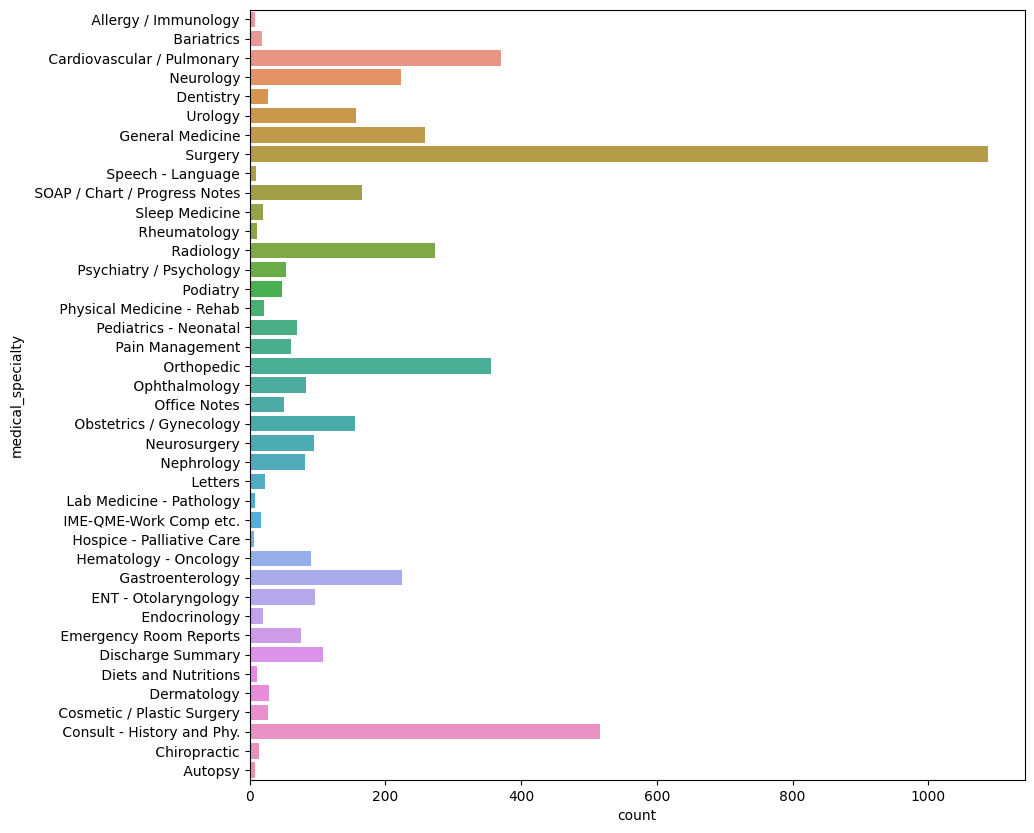

In [ ]:
# added
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = data_categories.filter(lambda x:x.shape[0]>0) )
plt.show()

In [ ]:
# added: one example for each category
unique_categories = clinical_text_df['medical_specialty'].unique()

transcriptions_per_category = []

for category in unique_categories:
    first_transcription = clinical_text_df.loc[clinical_text_df['medical_specialty'] == category, 'transcription'].iloc[0]
    transcriptions_per_category.append((category, first_transcription))

for category, transcription in transcriptions_per_category:
    print(f"Category: {category}\n")
    print(transcription)
    print('----------------------\n\n')

Category:  Allergy / Immunology

SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Ne

# Categories reduction

Some categories have less than 50 samples and others have a lot more. Minor categories are more difficult to classify since they offer less information and their presence increases the probability of errors. Thus, all categories with less than 50 samples were removed in this step.
By reducing the number of categories, focusing only on the major ones, allows for a more robust model with good generalization and reduced risk of overfitting.

In [ ]:
filtered_data_categories1 = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories1 = filtered_data_categories1.groupby(filtered_data_categories1['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories1:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')


============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


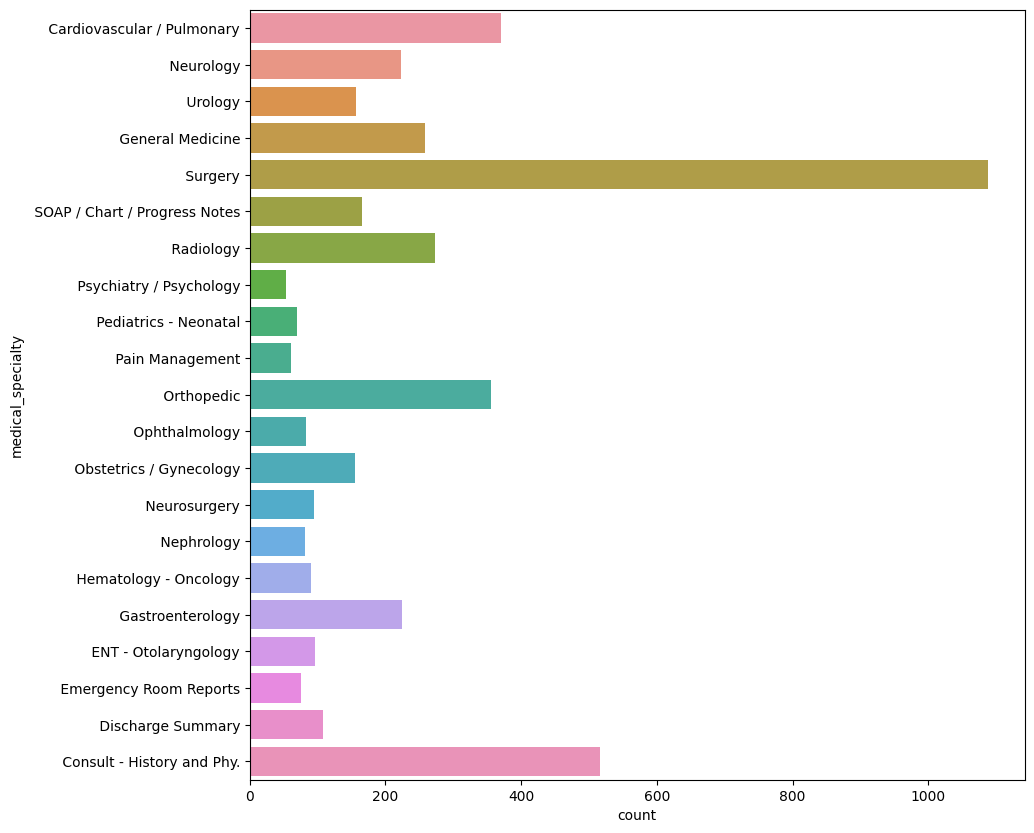

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories1 )
plt.show()

# Method 1

Since only 'transcription' and 'medical_specialty' columns are useful for the classification, create a new data.frame object.
Since the aim of the project is to create an automatic model from 'transcriptions', keywords won't be used, as they already are a manual elaboration.

In [ ]:
data1 = filtered_data_categories1[['transcription', 'medical_specialty']]
data1 = data1.drop(data1[data1['transcription'].isna()].index)
data1.shape

(4597, 2)

In [ ]:
print('Sample Transcription 1:'+data1.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data1.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data1.iloc[1000]['transcription'])

Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

## Cleaning data

"clean_text" function defined to: remove punctuation, remove numeric characters, joining together all the non-numeric characters, replace specific symbols with spaces, transform to lower case.

"lemmatize_text" function defined to tokenize and lemmatize using nltk package.

In [ ]:
# ORIGINAL
'''
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)

    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]

    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)
'''

"\ndef clean_text(text ):\n    text = text.translate(str.maketrans('', '', string.punctuation))\n    text1 = ''.join([w for w in text if not w.isdigit()])\n    REPLACE_BY_SPACE_RE = re.compile('[/(){}\\[\\]\\|@,;]')\n    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')\n\n    text2 = text1.lower()\n    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text\n    #text2 = BAD_SYMBOLS_RE.sub('', text2)\n    return text2\n\ndef lemmatize_text(text):\n    wordlist=[]\n    lemmatizer = WordNetLemmatizer()\n    sentences=sent_tokenize(text)\n\n    intial_sentences= sentences[0:1]\n    final_sentences = sentences[len(sentences)-2: len(sentences)-1]\n\n    for sentence in intial_sentences:\n        words=word_tokenize(sentence)\n        for word in words:\n            wordlist.append(lemmatizer.lemmatize(word))\n    for sentence in final_sentences:\n        words=word_tokenize(sentence)\n        for word in words:\n            wordlist.append(lemmatizer.l

Change in lemmatize_text function: instead of considering only the first and the last sentences of each transcription, it is more appropriate to include all the text.

Example to prove this necessity:

‘Gastroenterology’ Category

“HISTORY OF PRESENT ILLNESS:, Ms. Connor is a 50-year-old female who returns to clinic for a wound check.[...]  We will see her back in six months just for a general routine checkup and see how she is doing at that time.”

In [ ]:
# CHANGES
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)

    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)


In [ ]:
data1['transcription'] = data1['transcription'].apply(lemmatize_text)
data1['transcription'] = data1['transcription'].apply(clean_text)

In [ ]:
print('Sample Transcription 1:'+data1.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data1.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data1.iloc[1000]['transcription'])

Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation   week prior to presentation  she wa found  passed out  in bed  and when awoken appeared confused  and lethargic  she apparently recovered within  hour  for two week prior to presentation she demonstrated emotional lability  uncharacteristic of her  outburst of anger and inappropriate laughter   she left a stove on  she began slurring her speech  day prior to admission  on the day of presentation she developed right facial weakness and began stumbling to the right  she denied any associated headache  nausea  vomiting  fever  chill  neck stiffness or visual change  there wa no history of illicit drugetoh use or head trauma  pmh   migraine headache  fhx   unremarkable  shx   divorced  lives with boyfriend   child alive and well  denied tobaccoillicit drug use  rarely consumes etoh  ros   irregular menses  exam   bp  hr 

EXAMPLE. Beginning of a trascription, before and after processing:



BEFORE:

CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change.


AFTER:

cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation   week prior to presentation  she wa found  passed out  in bed  and when awoken appeared confused  and lethargic  she apparently recovered within  hour  for two week prior to presentation she demonstrated emotional lability  uncharacteristic of her  outburst of anger and inappropriate laughter   she left a stove on  she began slurring her speech  day prior to admission  on the day of presentation she developed right facial weakness and began stumbling to the right  she denied any associated headache  nausea  vomiting  fever  chill  neck stiffness or visual change

## Feature extraction with Tfidf

Feature extraction using TfidfVectorizer to generate tf-idf features.
In information retrieval, Tf–Idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The Tf–Idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general [6].

In [ ]:
# CHANGE: get_feature_names_out modified adding "_out"

# output: sparse matrix TF-IDF

# each param:
# analysis based on words (analyzer)
# during vectorizing process, removes english stopwords
# it will use, unigrams, bigrams and trigrams
# max_df removes words that appear in more than 75% of documents (common words assumed not informative)
# use_idf to abilitate Inverse Document Frequency computation
# smooth to prevent division by zero
# 1000 max number of features extracted

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat1  = vectorizer.fit_transform(data1['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdomen wa', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormality', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adequate', 'adhesion', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'alert oriented', 'allergies', 'alternative', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia wa', 'anesthetic', 'ankle', 'anterior', 'anteriorly', 'antibiotic', 'aorta', 'aortic', 'appear', 'appearance', 'appeared', 'appears', 'applied', 'appropriate', 'approximately', 'approximately cm', 'area', 'area wa', 'arm', 'artery', 'artery disease', 'artery wa', 'asked', 'aspect', 'aspiration', 'aspirin', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'attention', 'attention wa', 'attention wa turned', 'auscultation', 'axis', 'baby', 'balloon', 'base', 'based', 'bed', 'beg

#### T-SNE visualization

Visualization of the Tf-Idf features using T-SNE plot.
T-distributed Stochastic Neighbor Embedding (T-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability [7].

The t-sne plot shows that lot of categories are overlapping with each other.

Note: T-SNE is only useful to have an initial idea of the structure of the data, but really it doesn't give us any more information other than the fact that the dataset is noisy. We must also keep into account that it's a 2D representation of a dataset with much more dimensions.

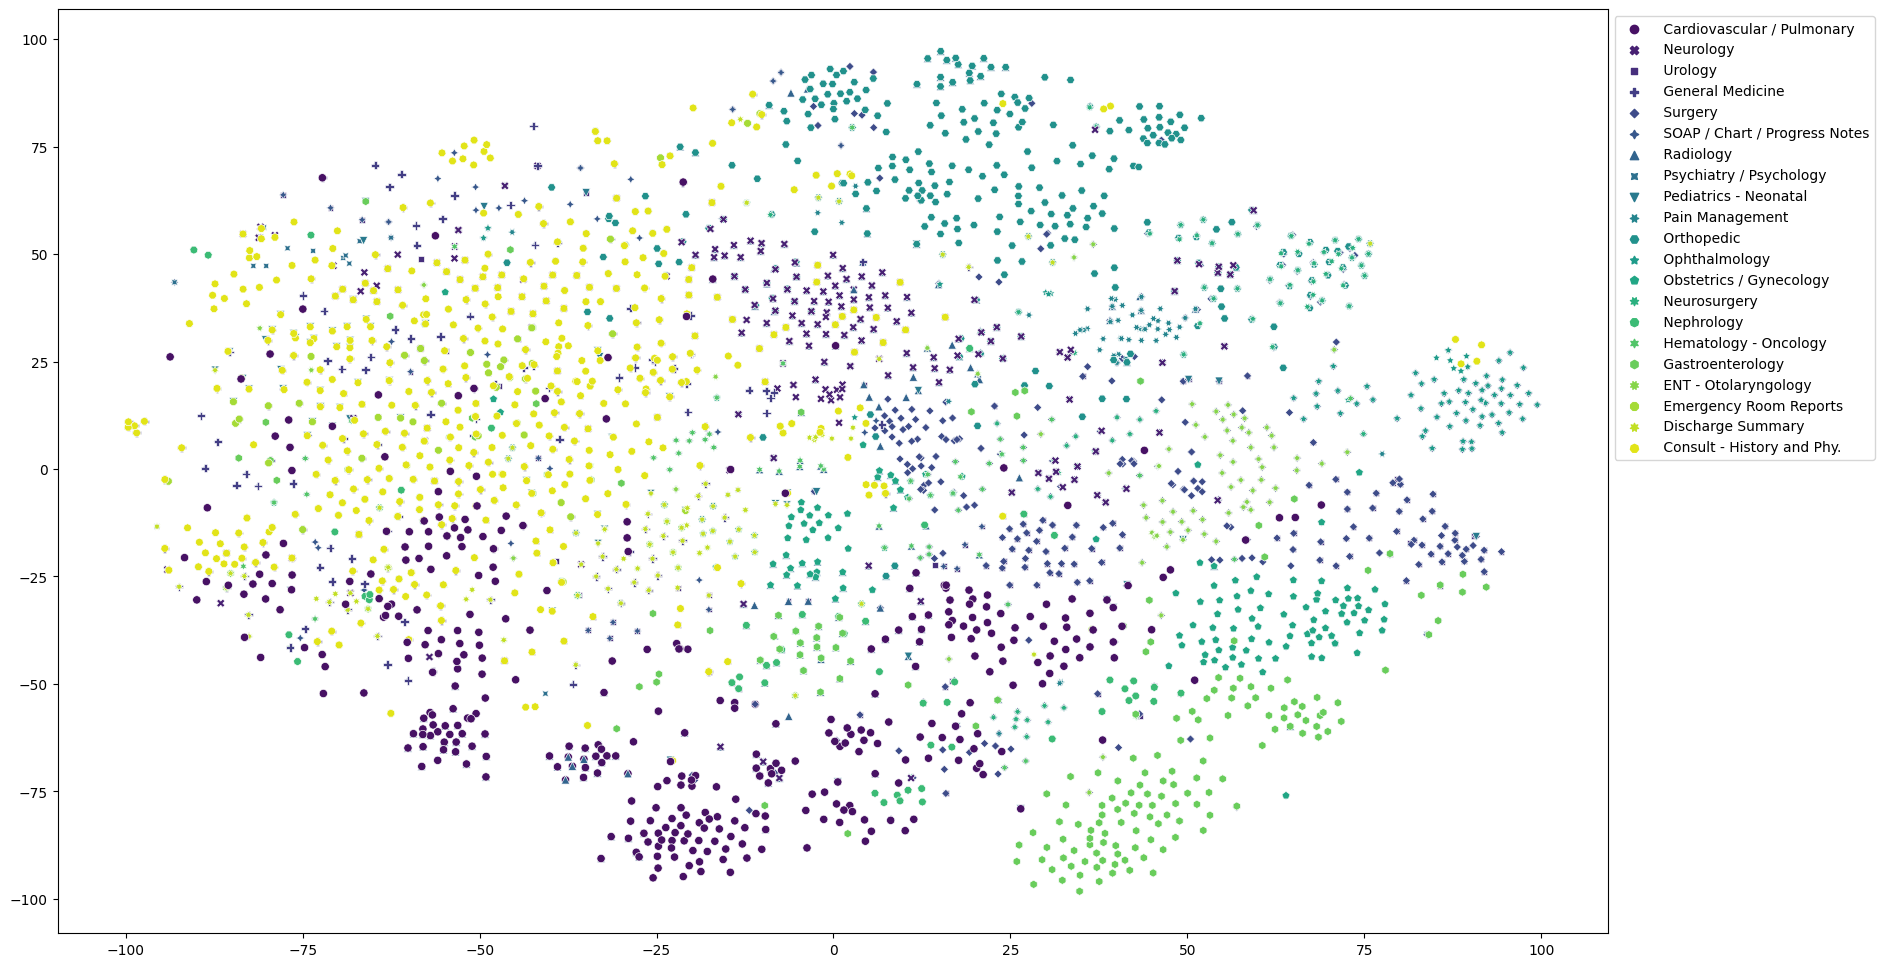

In [ ]:
# CHANGE: matrix tfIdfMatrix conversion to array using np.asarray()
gc.collect()
tfIdfMatrix = tfIdfMat1.todense()
labels = data1['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(np.asarray(tfIdfMatrix))
# perplexity parameter influences the visualization: 40 seems to be the most appropriate value, data are noisy though.

plt.figure(figsize=(20,12))

# ORIGINAL
# palette = sns.hls_palette(21, l=.6, s=.9)

# CHANGE
palette = sns.color_palette("viridis", 21)

# added
markers_list = data1['medical_specialty'].tolist()  # different markers for each category

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    style=markers_list,
    markers=True,
    palette= palette,
    legend="full"
)

# added
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.scatter([], [], s=0.2, label='Punti')

plt.show()

## Original code

In [ ]:
# ORIGINAL
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat1.toarray())
labels = data1['medical_specialty'].tolist()
category_list = data1.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

# creation of a logisticRegression object with elasticnet regolarization
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)

y_test_pred= clf.predict(X_test)

print(classification_report(y_test,y_test_pred,labels=category_list))

# performances acquired are not the same as the ones obtained in the original code
# since other changes have occured in the previous steps

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.42      0.38      0.40        93
                     Neurology       0.41      0.32      0.36        56
                       Urology       0.44      0.36      0.39        39
              General Medicine       0.25      0.17      0.20        65
                       Surgery       0.46      0.61      0.53       272
 SOAP / Chart / Progress Notes       0.41      0.45      0.43        42
                     Radiology       0.43      0.47      0.45        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.62      0.33      0.43        15
                    Orthopedic       0.41      0.36      0.38        89
                 Ophthalmology       0.53      0.43      0.47        21
       Obstetrics / Gynecology       0.36      0.26      0.30  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train-Test  dataset separation

If PCA is performed on the entire dataset before splitting it into train and test sets, information from the test set might leak into the training set through PCA. This could influence the model's ability to generalize to real-world data because the test set would have affected the PCA transformation.

In [ ]:
# CHANGE
X_train1, X_test1, y_train1, y_test1 = train_test_split(tfIdfMat1, labels, stratify=labels, random_state=1)
print('Train_Set_Size:'+str(X_train1.shape))
print('Test_Set_Size:'+str(X_test1.shape))

Train_Set_Size:(3447, 1000)
Test_Set_Size:(1150, 1000)


## Predictions - without PCA

#### Logistic regression
The best performances are obtained using a L1 penalty of 1 (basically equal to performing a Lasso).
Predictions using our model are worse compared to the original, which is to be expected as we didn't use PCA on the entire dataset.

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=1, random_state=1).fit(X_train1, y_train1)
y_test_pred1 = clf.predict(X_test1)
category_list = data1.medical_specialty.unique()
print(classification_report(y_test1,y_test_pred1,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.42      0.39      0.40        93
                     Neurology       0.35      0.25      0.29        56
                       Urology       0.40      0.36      0.38        39
              General Medicine       0.25      0.18      0.21        65
                       Surgery       0.47      0.63      0.54       272
 SOAP / Chart / Progress Notes       0.39      0.36      0.38        42
                     Radiology       0.33      0.31      0.32        68
       Psychiatry / Psychology       0.25      0.08      0.12        13
         Pediatrics - Neonatal       0.20      0.06      0.09        17
               Pain Management       0.71      0.33      0.45        15
                    Orthopedic       0.39      0.35      0.37        89
                 Ophthalmology       0.55      0.57      0.56        21
       Obstetrics / Gynecology       0.37      0.38      0.37  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


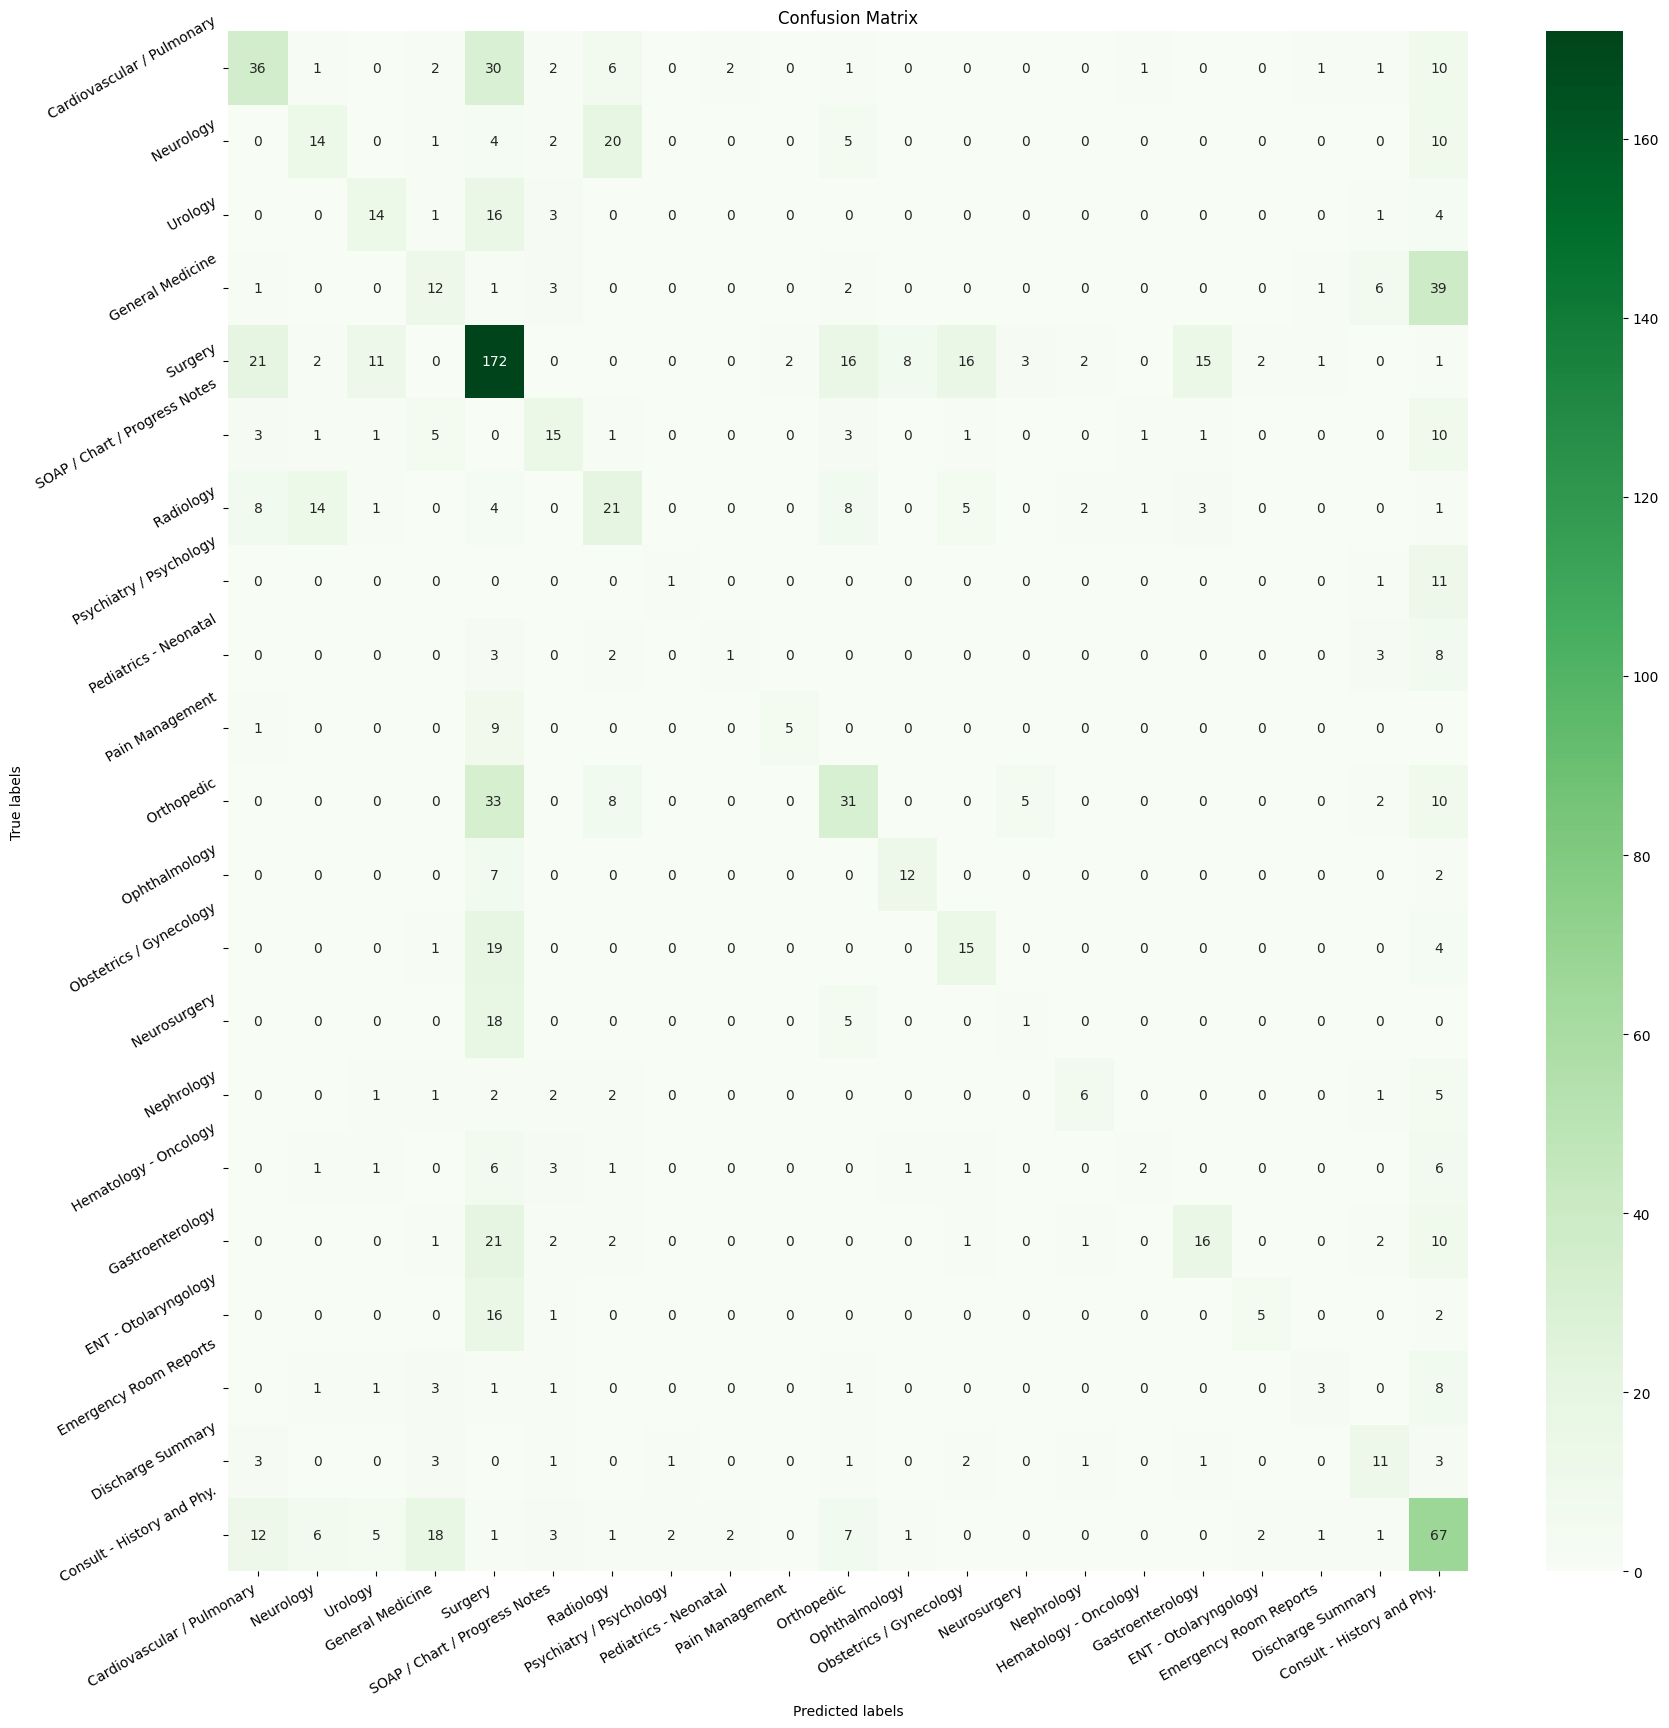

In [ ]:
cm = confusion_matrix(y_test1, y_test_pred1, labels=category_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

#### SMOTE & LR
Since some classes are in minority we can use SMOTE (Synthetic Minority Over-sampling Technique
), which is a technique to generate more sample for minority class to solve the data imbalance problem [8], as highlighted in the study of Ferraio et al.[3].

Generate new training dataset using SMOTE and then perform classification on them.

Note: improvements can be better appreciated from F1-scores, precision and recall values rather than from confusion matrix.


In [ ]:
# CHANGE: apply SMOTE only on training set
smote_over_sample = SMOTE(sampling_strategy='minority')
X_train_smote1, y_train_smote1 = smote_over_sample.fit_resample(X_train1, y_train1)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1, random_state=1).fit(X_train_smote1, y_train_smote1)
y_test_pred_smote1 = clf.predict(X_test1)
print(classification_report(y_test1, y_test_pred_smote1, labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.42      0.39      0.40        93
                     Neurology       0.36      0.27      0.31        56
                       Urology       0.40      0.36      0.38        39
              General Medicine       0.22      0.17      0.19        65
                       Surgery       0.48      0.63      0.54       272
 SOAP / Chart / Progress Notes       0.39      0.36      0.38        42
                     Radiology       0.33      0.31      0.32        68
       Psychiatry / Psychology       0.38      0.69      0.49        13
         Pediatrics - Neonatal       0.17      0.06      0.09        17
               Pain Management       0.71      0.33      0.45        15
                    Orthopedic       0.42      0.37      0.39        89
                 Ophthalmology       0.55      0.57      0.56        21
       Obstetrics / Gynecology       0.37      0.38      0.37  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


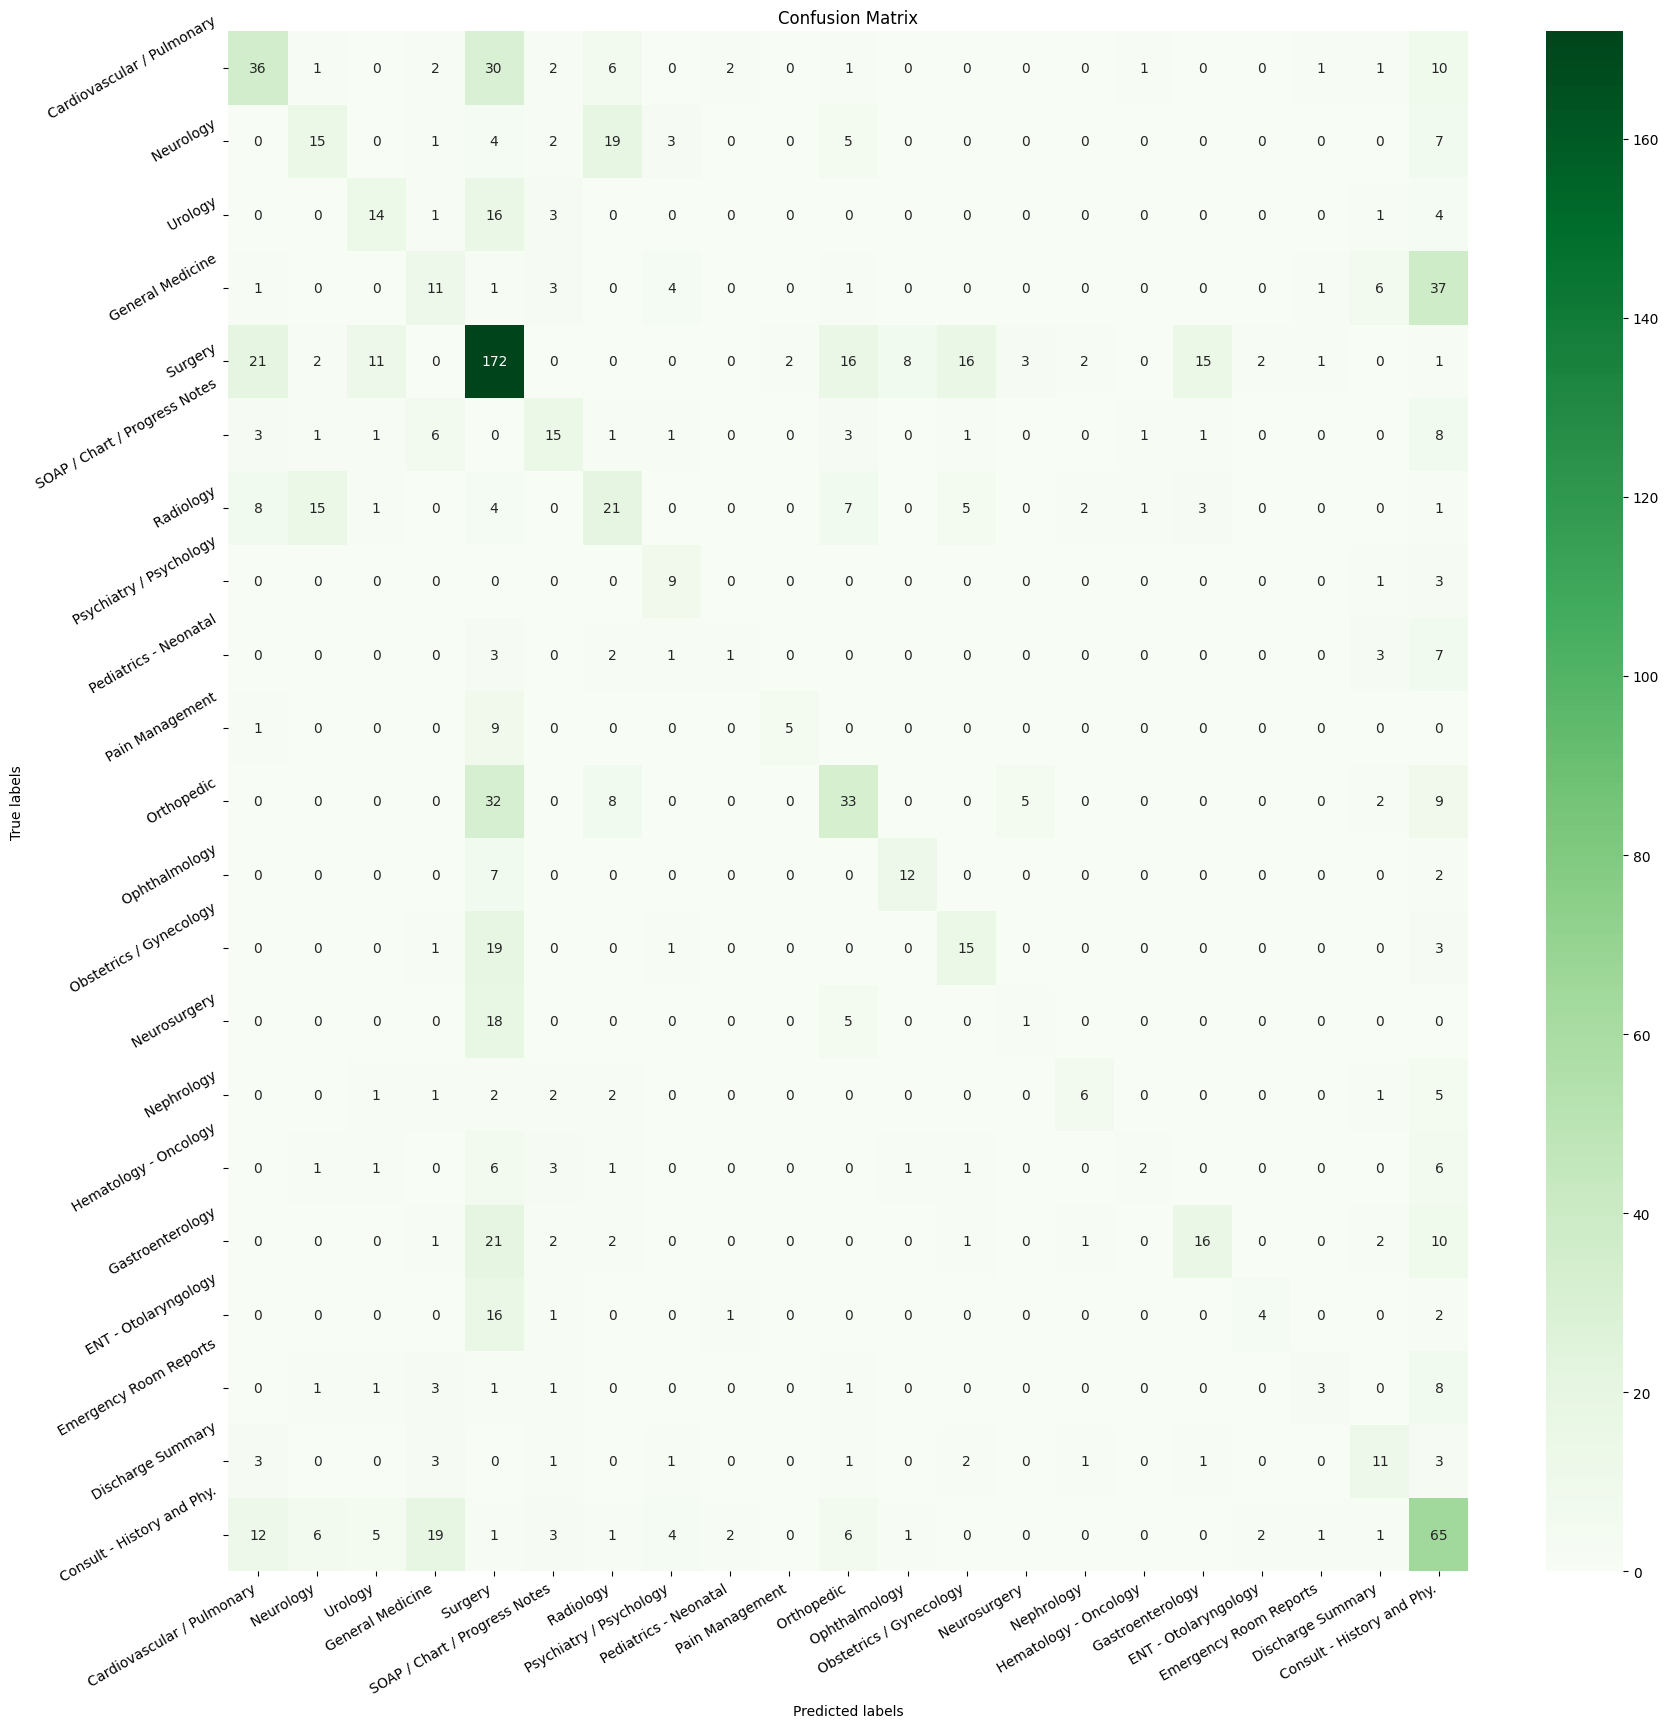

In [ ]:
cm = confusion_matrix(y_test1, y_test_pred_smote1, labels=category_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

F1-score of minority classes (i.e., Psychiatry / Psychology) has improved (from 0.12 to 0.49), as well as the accuracy (from 40% to 41%).



In the confusion matrix everything is predicted as 'Surgery' and as 'Consult'. 'Surgery' is often mispredicted; 'Radiology' is predicted mostly as 'Neurology' and viceversa. Moreover, the less represented categories are rarely correctly predicted.
These are the main reasons behind the categories reduction implemented in Method 2.

## Prediction - with PCA

PCA to reduce dimensionality of features.
PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on [9].

In [ ]:
# CHANGE: PCA only on train set
pca = PCA(n_components=0.95)
X_train_pca1 = pca.fit_transform(X_train1.toarray())
X_test_pca1 = pca.transform(X_test1.toarray())
print('Train_Set_Size:'+str(X_train_pca1.shape))
print('Test_Set_Size:'+str(X_test_pca1.shape))

# dimensionality reduction

Train_Set_Size:(3447, 581)
Test_Set_Size:(1150, 581)


### Logistic Regression

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=1, random_state=1).fit(X_train_pca1, y_train1)
y_test_pred_pca1 = clf.predict(X_test_pca1)
category_list = data1.medical_specialty.unique()
print(classification_report(y_test1,y_test_pred_pca1,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.44      0.39      0.41        93
                     Neurology       0.42      0.30      0.35        56
                       Urology       0.47      0.36      0.41        39
              General Medicine       0.24      0.17      0.20        65
                       Surgery       0.48      0.62      0.54       272
 SOAP / Chart / Progress Notes       0.39      0.33      0.36        42
                     Radiology       0.46      0.51      0.49        68
       Psychiatry / Psychology       0.67      0.15      0.25        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.67      0.53      0.59        15
                    Orthopedic       0.44      0.48      0.46        89
                 Ophthalmology       0.55      0.52      0.54        21
       Obstetrics / Gynecology       0.38      0.28      0.32  

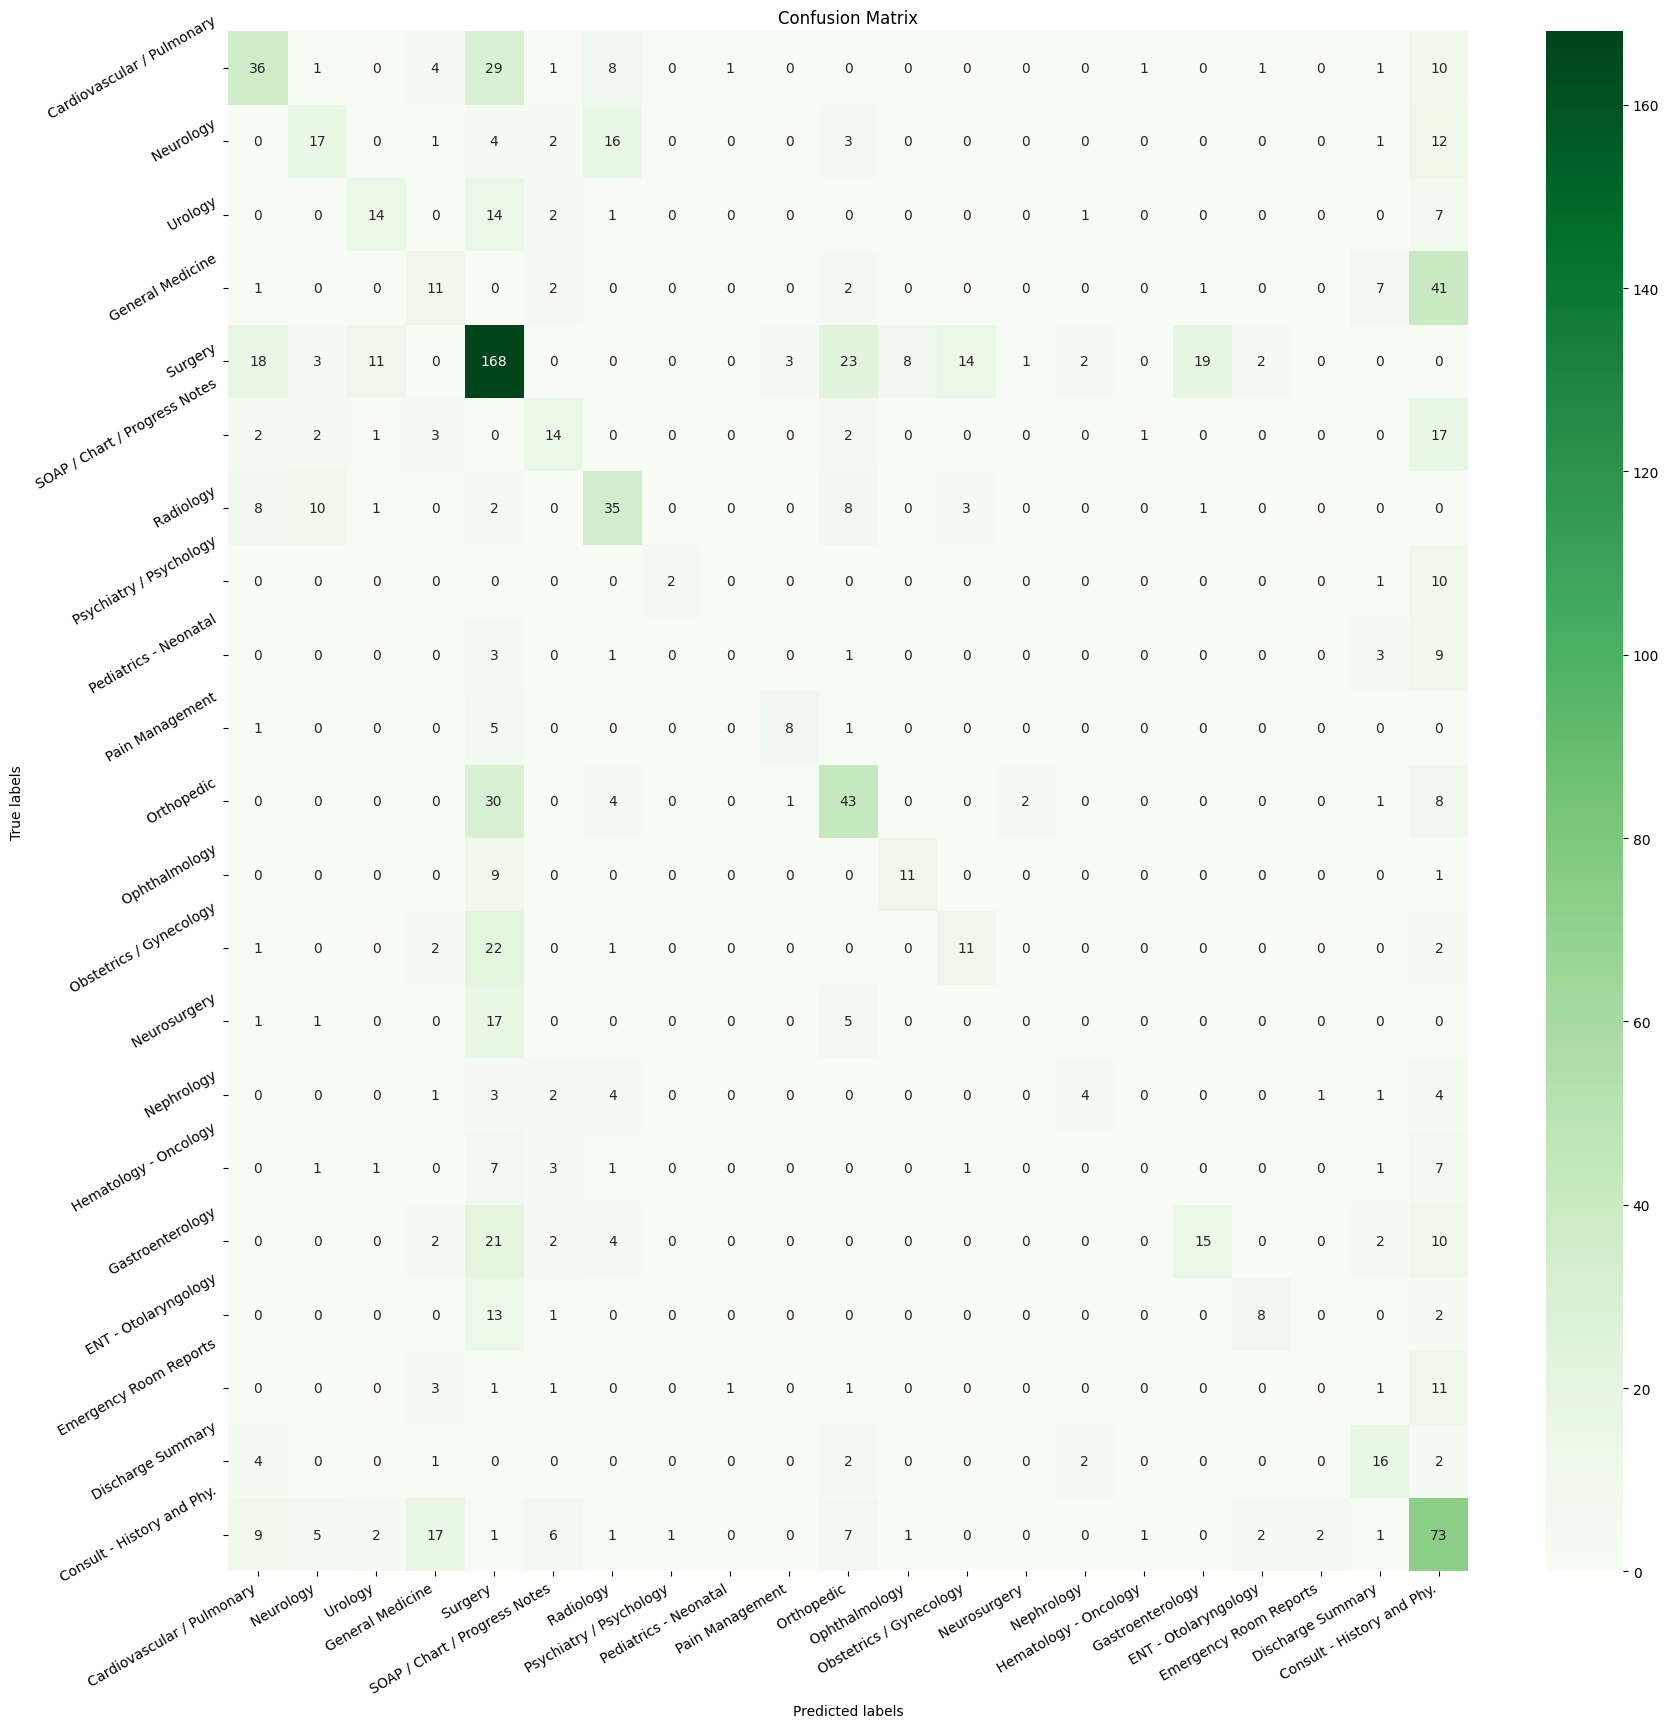

In [ ]:
cm = confusion_matrix(y_test1, y_test_pred_pca1, labels=category_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### SMOTE & LR

In [ ]:
smote_over_sample = SMOTE(sampling_strategy='minority')
X_train_smote_pca1, y_train_smote_pca1 = smote_over_sample.fit_resample(X_train_pca1, y_train1)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1, random_state=1).fit(X_train_smote_pca1, y_train_smote_pca1)
y_test_pred_smote_pca1 = clf.predict(X_test_pca1)
print(classification_report(y_test1, y_test_pred_smote_pca1, labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.44      0.39      0.41        93
                     Neurology       0.41      0.30      0.35        56
                       Urology       0.46      0.33      0.39        39
              General Medicine       0.25      0.17      0.20        65
                       Surgery       0.48      0.62      0.54       272
 SOAP / Chart / Progress Notes       0.39      0.33      0.36        42
                     Radiology       0.46      0.51      0.49        68
       Psychiatry / Psychology       0.36      0.69      0.47        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.67      0.53      0.59        15
                    Orthopedic       0.45      0.48      0.46        89
                 Ophthalmology       0.55      0.52      0.54        21
       Obstetrics / Gynecology       0.38      0.28      0.32  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


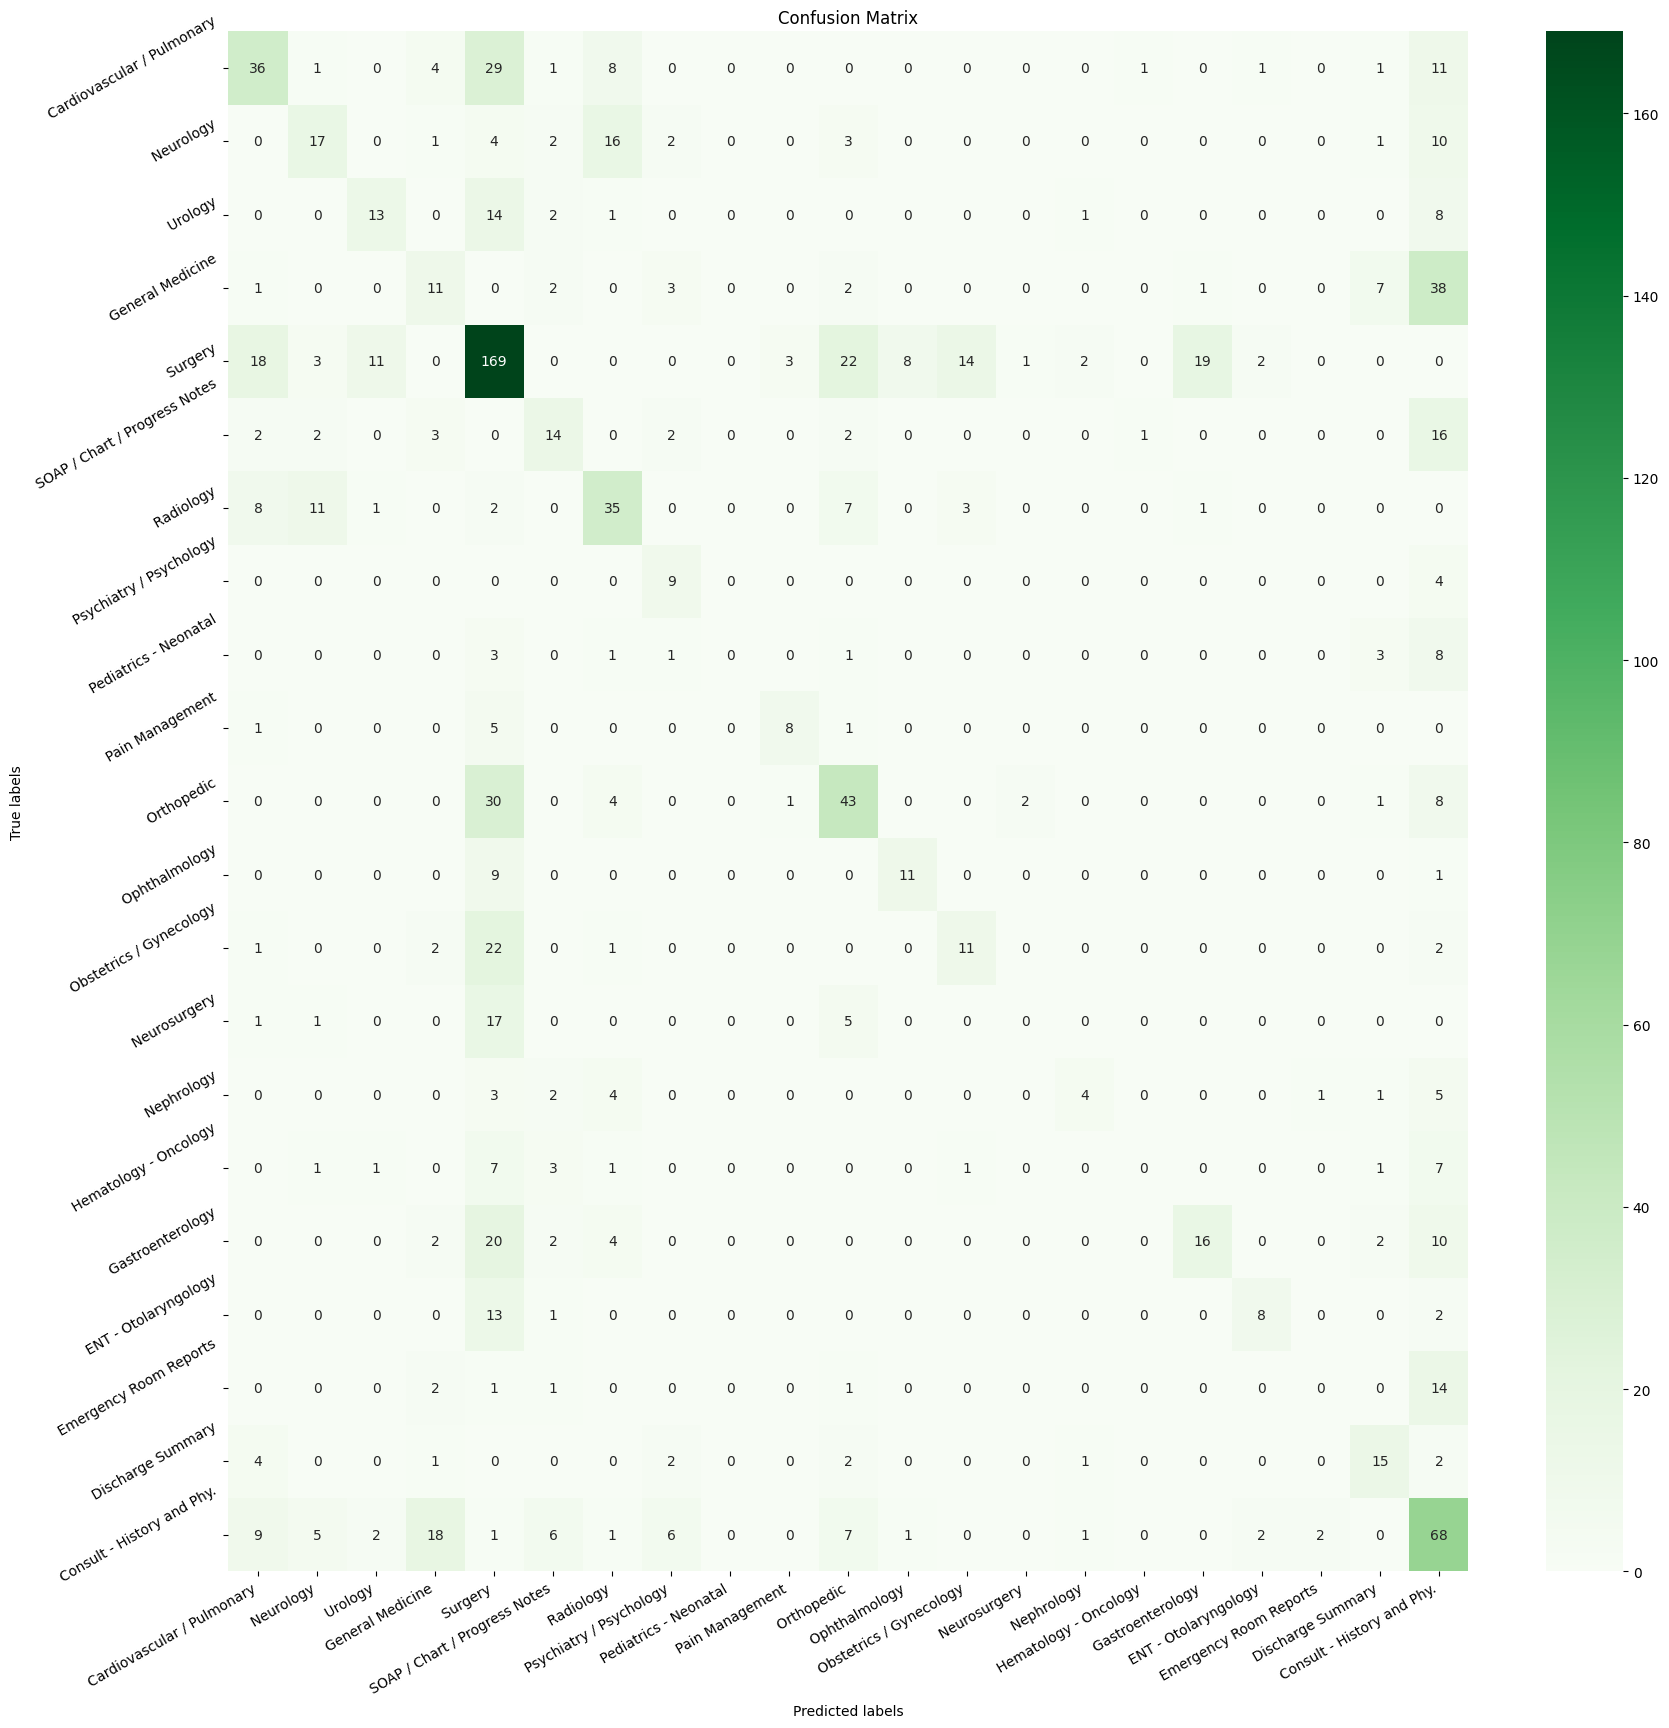

In [ ]:
cm = confusion_matrix(y_test1, y_test_pred_smote_pca1, labels=category_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

After PCA, some categories are not predicted at all.
With or without PCA there are no major differences.
SMOTE seems to be useful as it consistently improves minor categories.

PCA aims to retain the maximum variance in the data but might not take into account specific relationships or unique characteristics of certain categories. Dimensionality reduction could lead to the loss of crucial information that might be relevant for predicting specific categories. It also might not be ideal for category separation. This can make it more challenging for the model to correctly identify some less represented or more complex categories.

# Method 2

See if results improve by applying some domain knowledge.
The 'Surgery' category is kind of superset as there can be surgeries belonging to specializations like 'Cardiology', 'Neurology' etc. Similarly other categories like 'Emergency Room Reports', 'Discharge Summary', 'Notes' also overlap with specialities. Hence, we should try to remove them.

In [ ]:
filtered_data_categories2 = filtered_data_categories1.copy()
filtered_data_categories2['medical_specialty'] = filtered_data_categories2['medical_specialty'].apply(lambda x:str.strip(x))

# added: for the same reason as the others have been removed
mask = filtered_data_categories2['medical_specialty'] == 'Radiology'
filtered_data_categories2 = filtered_data_categories2[~mask]

mask = filtered_data_categories2['medical_specialty'] == 'Surgery'
filtered_data_categories2 = filtered_data_categories2[~mask]

mask = filtered_data_categories2['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories2 = filtered_data_categories2[~mask]
mask = filtered_data_categories2['medical_specialty'] == 'Office Notes'
filtered_data_categories2 = filtered_data_categories2[~mask]
mask = filtered_data_categories2['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories2 = filtered_data_categories2[~mask]
mask = filtered_data_categories2['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories2 = filtered_data_categories2[~mask]
mask = filtered_data_categories2['medical_specialty'] == 'Discharge Summary'
filtered_data_categories2 = filtered_data_categories2[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories2['medical_specialty'] == 'Pain Management'
filtered_data_categories2 = filtered_data_categories2[~mask]
mask = filtered_data_categories2['medical_specialty'] == 'General Medicine'
filtered_data_categories2 = filtered_data_categories2[~mask]


mask = filtered_data_categories2['medical_specialty'] == 'Neurosurgery'
filtered_data_categories2.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories2['medical_specialty'] == 'Nephrology'
filtered_data_categories2.loc[mask, 'medical_specialty'] = 'Urology'

final_data_categories = filtered_data_categories2.groupby(filtered_data_categories2['medical_specialty'])

i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data2 = filtered_data_categories2[['transcription', 'medical_specialty']]
data2 = data2.drop(data2[data2['transcription'].isna()].index)
data2.shape

# saved for word2vec
data_w2v = data2.copy()

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 ENT - Otolaryngology : 96
Cat:3 Gastroenterology : 224
Cat:4 Hematology - Oncology : 90
Cat:5 Neurology : 317
Cat:6 Obstetrics / Gynecology : 155
Cat:7 Ophthalmology : 83
Cat:8 Orthopedic : 355
Cat:9 Pediatrics - Neonatal : 70
Cat:10 Psychiatry / Psychology : 53
Cat:11 Urology : 237
============Reduced Categories======================


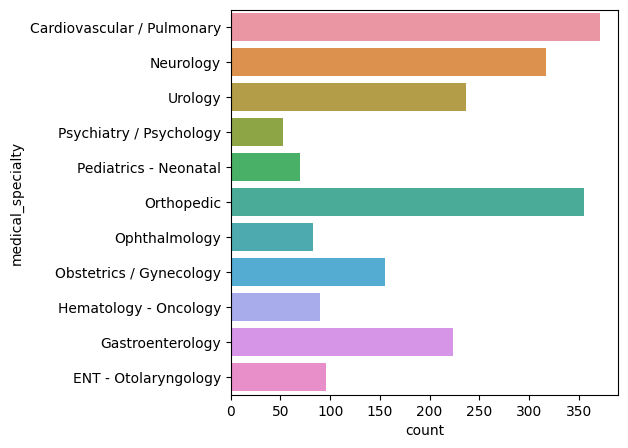

In [ ]:
# added
plt.figure(figsize=(5,5))
sns.countplot(y='medical_specialty', data = final_data_categories.filter(lambda x:x.shape[0]>0) )
plt.show()

In [ ]:
print('Sample Transcription 1:'+data2.iloc[1]['transcription']+'\n')
print('Sample Transcription 2:'+data2.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data2.iloc[1000]['transcription'])

Sample Transcription 1:1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral 

### Medical entities detection with spaCy

SpaCy models to detect medical entities in our text.

The selected model (en_ner_bionlp13cg_md) is the one with the most words and it is particulalry appropriate for our aims[10].
scispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text, and its usage was found to be effective in the studies by Jentsch et al.[5], by Pruneski et al.[1] and by Arivazhagan et al.[2].

After SpaCy, some transcriptions are removed because they don't have medical enitities and result as void.

In [ ]:
# spaCy model
nlp = en_ner_bionlp13cg_md.load()

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


"process_Text" function defined to apply nlp method, that identifies biomedical entities.

In [ ]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

In [ ]:
data2['transcription'] = data2['transcription'].apply(process_Text)

In [ ]:
# added: check for empty transcriptions
k=0
idx_empty=[]
for ii in range(0,data2.shape[0]):
  subj=data2.iloc[ii]
  trans=subj['transcription']
  if len(trans)==0:
     idx_empty.append(ii)
     k=k+1
print('Number of empty transcription:'+str(k))
print(idx_empty)

Number of empty transcription:17
[11, 170, 176, 291, 321, 327, 328, 445, 469, 480, 696, 1118, 1411, 1486, 1732, 1733, 1804]


In [ ]:
# added: since after spaCy processing some transcriptions are empty, drop them from data2
data2 = data2.reset_index(drop=True)
data2 = data2.drop(idx_empty)
print(data2.shape)

# decide to drop them also from data_w2v, to provide a paired comparison later
data_w2v = data_w2v.reset_index(drop=True)
data_w2v = data_w2v.drop(idx_empty)
print(data_w2v.shape)

(2034, 2)
(2034, 2)


In [ ]:
# saved for word2vec
data2_spaCy = data2.copy()

In [ ]:
data2['transcription'] = data2['transcription'].apply(lemmatize_text)
data2['transcription'] = data2['transcription'].apply(clean_text)

In [ ]:
print('Medical Specialty 1:'+data2.iloc[1]['medical_specialty']+'\n')
print('Sample Transcription 1:'+data2.iloc[1]['transcription']+'\n')
print('Medical Specialty 2:'+data2.iloc[125]['medical_specialty']+'\n')
print('Sample Transcription 2:'+data2.iloc[125]['transcription']+'\n')
print('Medical Specialty 3:'+data2.iloc[900]['medical_specialty']+'\n')
print('Sample Transcription 3:'+data2.iloc[900]['transcription'])

Medical Specialty 1:Cardiovascular / Pulmonary

Sample Transcription 1:wall wall right atrium aortic root aortic valve aortic valve aortic valve mitral annular mitral valve mitral tricuspid valve pulmonary artery pulmonary artery pulmonary valve pulmonary intracardiac foramen lipomatous hypertrophy interatrial

Medical Specialty 2:Urology

Sample Transcription 2:ta grade iii tis transitional cell carcinoma urinary lower tract ta grade iii tis transitional cell carcinoma urinary lower tract prostate laryngeal patient bladder cancer bladder cancer cystoscopy tumor ta grade iii transitional cell carcinoma carcinoma ureteroscopy lower urinary tract patient biopsy site bladder cystoscopy bladder neck bph patient cystoscopy bilobular prostatic hyperplasia bladder mucosal midline carcinoma patient cystoscopy laryngeal perineum cystourethroscopy meatus bladder ureteral orifice bladder neck bladder neck anterior stromal tissue apical tissue patient supine

Medical Specialty 3:Neurology

Sample 

EXAMPLE: beginning of a transcription belonging to the 'Urology' category before and after processing.


BEFORE:

PREOPERATIVE DIAGNOSES:,1.  Right renal mass.,2.  Hematuria.,POSTOPERATIVE DIAGNOSES:,1.  Right renal mass.,2.  Right ureteropelvic junction obstruction.,PROCEDURES PERFORMED:,1.  Cystourethroscopy.,2.  Right retrograde pyelogram.,3.  Right ureteral pyeloscopy.,4.  Right renal biopsy.,5.  Right double-J 4.5 x 26 mm ureteral stent placement.,ANESTHESIA: , Sedation.,SPECIMEN: , Urine for cytology and culture sensitivity, right renal pelvis urine for cytology, and right upper pole biopsies (...)


AFTER:

right renal right renal ureteral right renal ureteral stent urine urine patient cat kidney patient supine  ureter patient bladder patient prostate bladder patient bladder upper collecting ureteral catheter bladder bladder ureter upj ureteral dilating sheath amplatz wire sheath ureter upj ureter upj upj upper papillary biopsy forceps biopsy papillary bladder ureteral stent cystoscopic right renal pelvis right renal pelvis bladder bladder patient patient patient



### Feature extraction with Tfidf

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat2  = vectorizer.fit_transform(data2['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen bowel', 'abdomen patient', 'abdomen pelvis', 'abdominal', 'abdominal cavity', 'abdominal wall', 'abds', 'achilles', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adnexal', 'adrenal', 'adrenal gland', 'airway', 'airway patient', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'alt', 'ancef', 'anesthesia', 'annular', 'anterior', 'anterior abdominal', 'anterior abdominal wall', 'anterior border', 'anterior border sternocleidomastoid', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior lip', 'anterior posterior', 'anterior wall', 'antrum', 'aorta', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery carotid', 'artery carotid artery', 'artery coronary', 'artery coronary artery', 'artery femoral', 'artery left', 'artery patient', 'artery pulmonary', 'artery pulmonary artery', 'artery vessel', 'articular', 'aspirin', 'ast', 'ast alt', 'atrial

#### T-SNE visualization

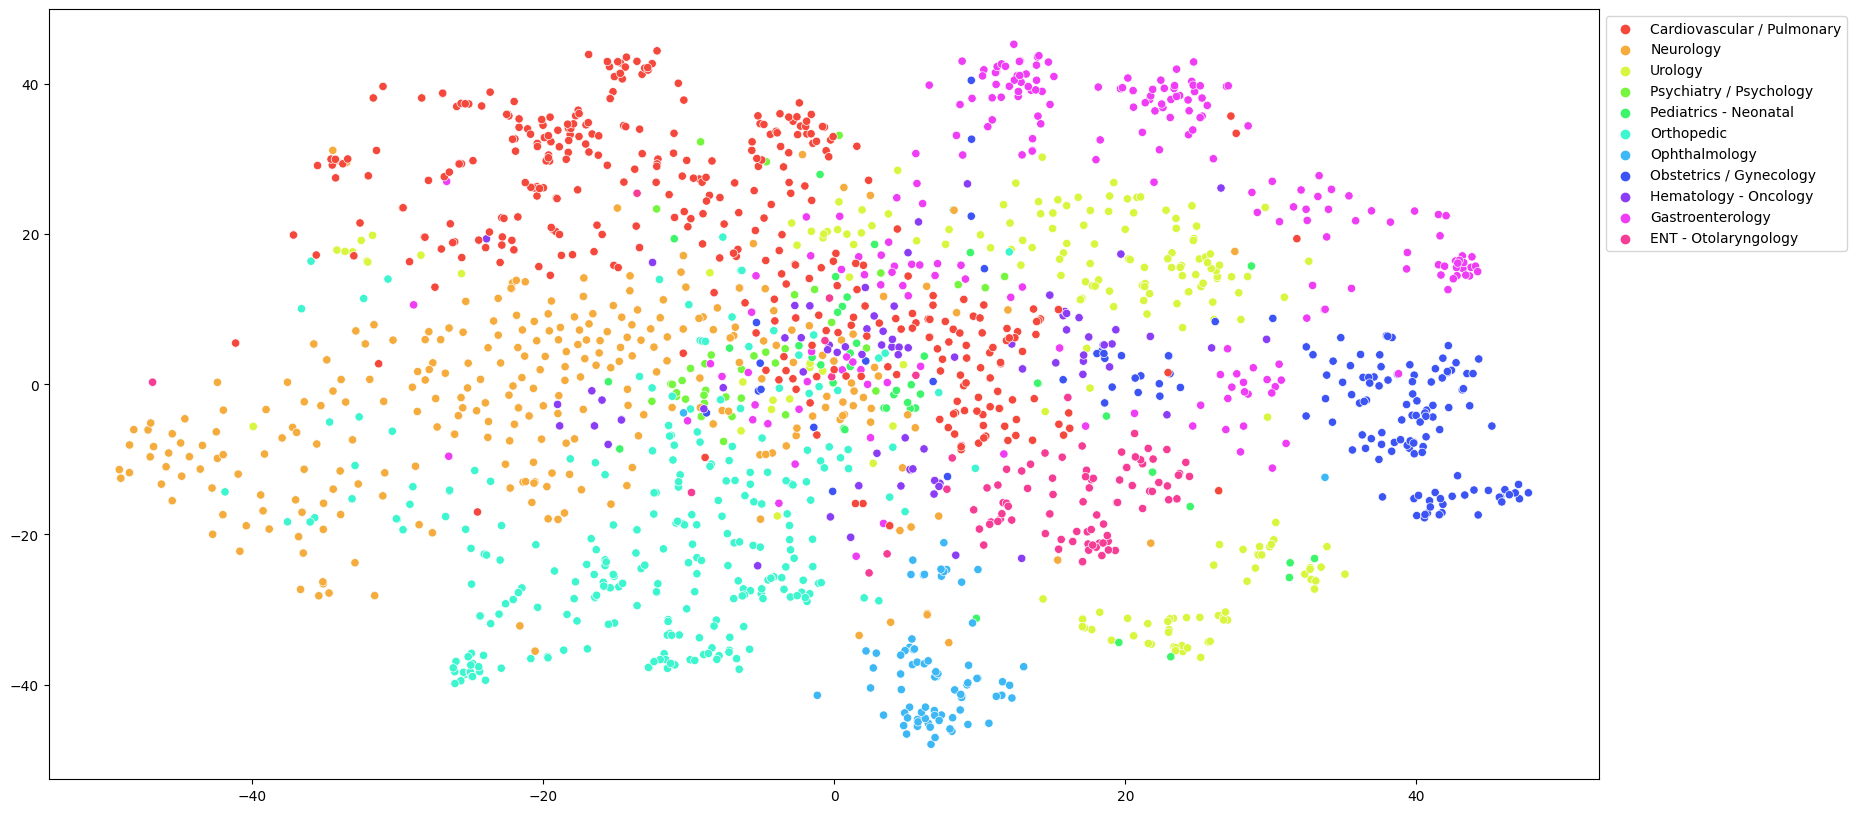

In [ ]:
gc.collect()
tfIdfMatrix = tfIdfMat2.todense()
labels = data2['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=30).fit_transform(np.asarray(tfIdfMatrix))

plt.figure(figsize=(20,10))
palette = sns.hls_palette(11, l=.6, s=.9)

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.scatter([], [], s=0.2, label='Punti')

plt.show()


There are no distinguishable clusters. There are areas in which aggregations  can be seen, but there is a lot of superimposition.

### Train-Test dataset separation

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(tfIdfMat2, labels, stratify=labels, random_state=1)
print('Train_Set_Size:'+str(X_train2.shape))
print('Test_Set_Size:'+str(X_test2.shape))

Train_Set_Size:(1525, 1000)
Test_Set_Size:(509, 1000)


### Predictions - without PCA

#### Logistic regression
Best performances are obtained using a L1 penalty of 0.2, meaning that a less aggressive approach, closer to Ridge, was more performing.

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.2, random_state=1).fit(X_train2, y_train2)
y_test_pred2 = clf.predict(X_test2)
category_list = data2.medical_specialty.unique()
print(classification_report(y_test2,y_test_pred2,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.81      0.95      0.87        92
                 Neurology       0.61      0.65      0.63        79
                   Urology       0.85      0.85      0.85        59
   Psychiatry / Psychology       0.64      0.54      0.58        13
     Pediatrics - Neonatal       0.83      0.29      0.43        17
                Orthopedic       0.72      0.80      0.76        87
             Ophthalmology       0.94      0.80      0.86        20
   Obstetrics / Gynecology       0.90      0.90      0.90        39
     Hematology - Oncology       0.73      0.35      0.47        23
          Gastroenterology       0.84      0.86      0.85        56
      ENT - Otolaryngology       0.95      0.83      0.89        24

                  accuracy                           0.78       509
                 macro avg       0.80      0.71      0.74       509
              weighted avg       0.78      0.7

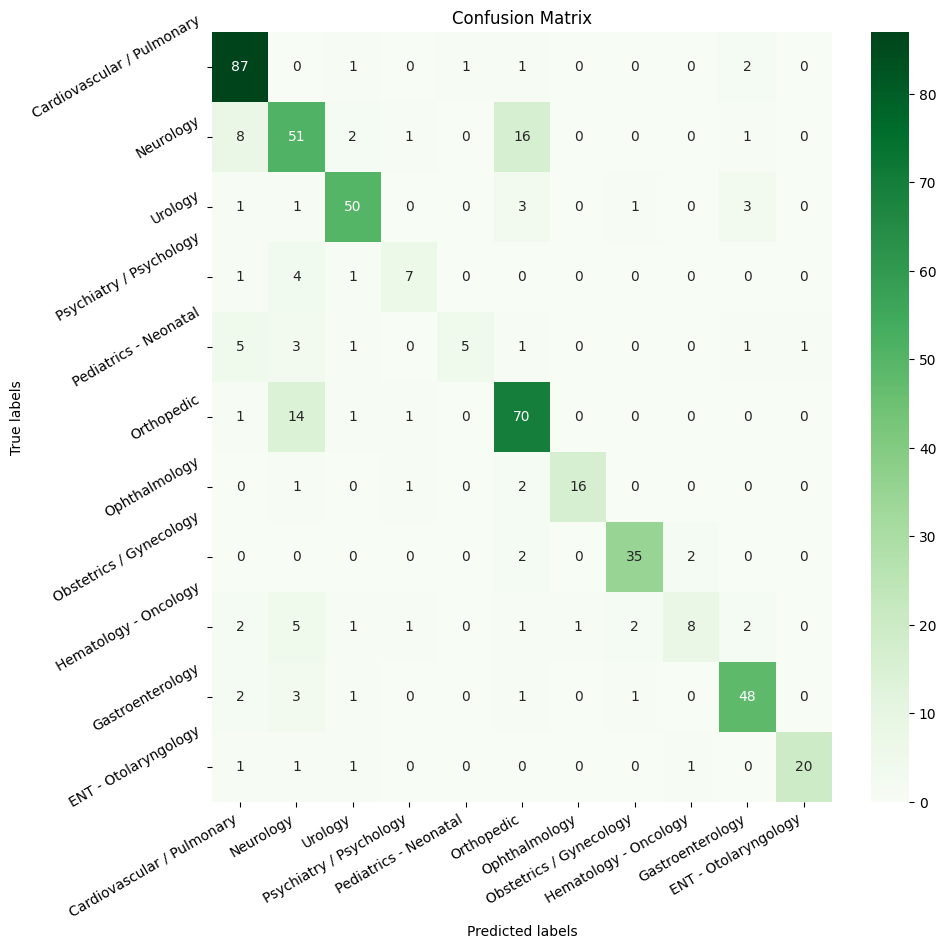

In [ ]:
cm = confusion_matrix(y_test2, y_test_pred2, labels=category_list)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

'Neurology' and 'Orthopedic' are confused.
'Pediatrics', 'Hematology' and 'Psychiatry/Psychology' are spread out with 'Neurolgy' and 'Cardiovascular/Pulmonary'.

#### SMOTE & LR

SMOTE used with the ‘auto’ sampling_strategy, that automatically balances all the minority classes.

In [ ]:
# ORIGINAL
# with 'minority' only the smallest category was balanced
# smote_over_sample = SMOTE(sampling_strategy='minority')

In [ ]:
# CHANGE: sampling_strategy='auto'
# with 'auto' SMOTE automatically balances all the minority classes
smote_over_sample = SMOTE(sampling_strategy='auto')
X_train_smote2, y_train_smote2 = smote_over_sample.fit_resample(X_train2, y_train2)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, random_state=1).fit(X_train_smote2, y_train_smote2)
y_test_pred_smote2 = clf.predict(X_test2)
print(classification_report(y_test2, y_test_pred_smote2, labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.85      0.89      0.87        92
                 Neurology       0.68      0.61      0.64        79
                   Urology       0.85      0.76      0.80        59
   Psychiatry / Psychology       0.50      0.85      0.63        13
     Pediatrics - Neonatal       0.35      0.35      0.35        17
                Orthopedic       0.74      0.75      0.74        87
             Ophthalmology       0.94      0.85      0.89        20
   Obstetrics / Gynecology       0.88      0.90      0.89        39
     Hematology - Oncology       0.46      0.52      0.49        23
          Gastroenterology       0.83      0.79      0.81        56
      ENT - Otolaryngology       0.79      0.79      0.79        24

                  accuracy                           0.75       509
                 macro avg       0.71      0.73      0.72       509
              weighted avg       0.76      0.7

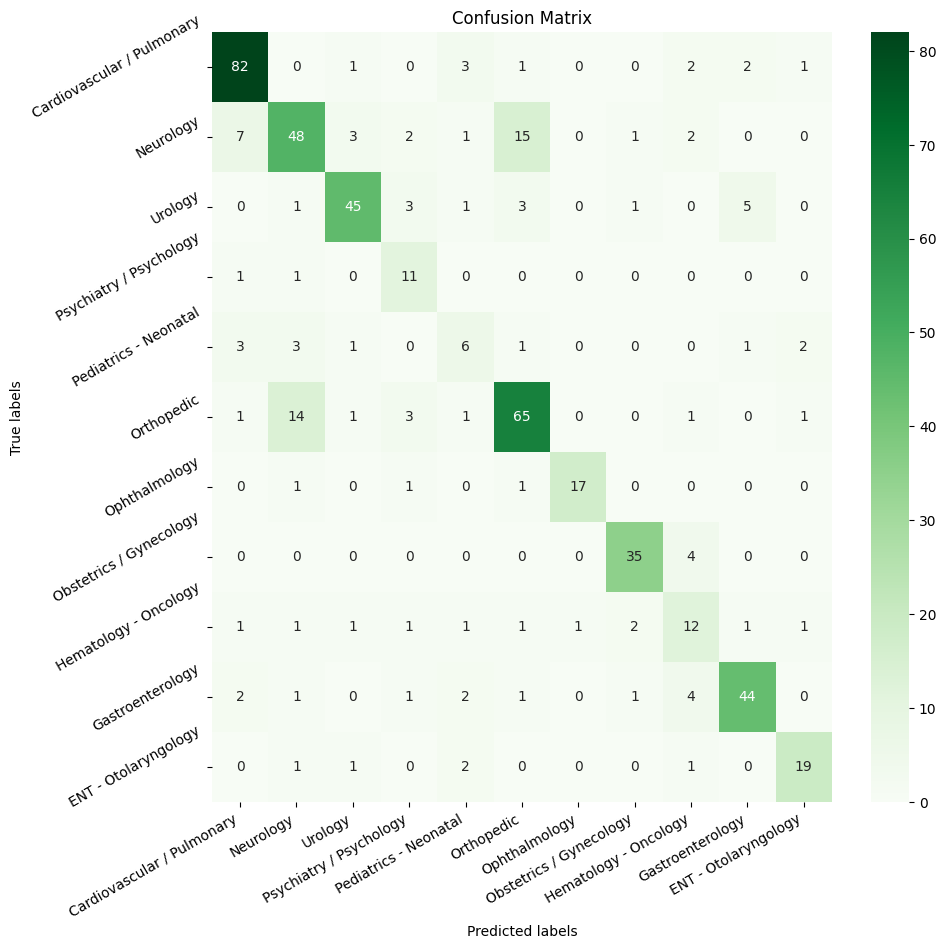

In [ ]:
cm = confusion_matrix(y_test2, y_test_pred_smote2, labels=category_list)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

With SMOTE F1-scores of minority classes ('Hematology' and 'Psychiatry') improve, the accuracy is a little lower compare to the previous, since balancing we are reducing F1-score of major categories.
'Pediatrics' slightly improves in its recall value and one more subject is correctly predicted with respect to the LR without SMOTE.
We accept a slightly worsened majority class for an improved diagonal and with 'auto' all minor classes are balanced.

### Prediction - with PCA

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca2 = pca.fit_transform(X_train2.toarray())
X_test_pca2 = pca.transform(X_test2.toarray())
print('Train_Set_Size:'+str(X_train_pca2.shape))
print('Test_Set_Size:'+str(X_test_pca2.shape))

Train_Set_Size:(1525, 544)
Test_Set_Size:(509, 544)


#### Logistic Regression

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.2, random_state=1).fit(X_train_pca2, y_train2)
y_test_pred_pca2 = clf.predict(X_test_pca2)
category_list = data2.medical_specialty.unique()
print(classification_report(y_test2,y_test_pred_pca2,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.79      0.93      0.86        92
                 Neurology       0.60      0.62      0.61        79
                   Urology       0.85      0.88      0.87        59
   Psychiatry / Psychology       0.70      0.54      0.61        13
     Pediatrics - Neonatal       0.80      0.24      0.36        17
                Orthopedic       0.72      0.82      0.76        87
             Ophthalmology       0.94      0.80      0.86        20
   Obstetrics / Gynecology       0.89      0.87      0.88        39
     Hematology - Oncology       0.75      0.39      0.51        23
          Gastroenterology       0.82      0.82      0.82        56
      ENT - Otolaryngology       0.95      0.83      0.89        24

                  accuracy                           0.77       509
                 macro avg       0.80      0.70      0.73       509
              weighted avg       0.78      0.7

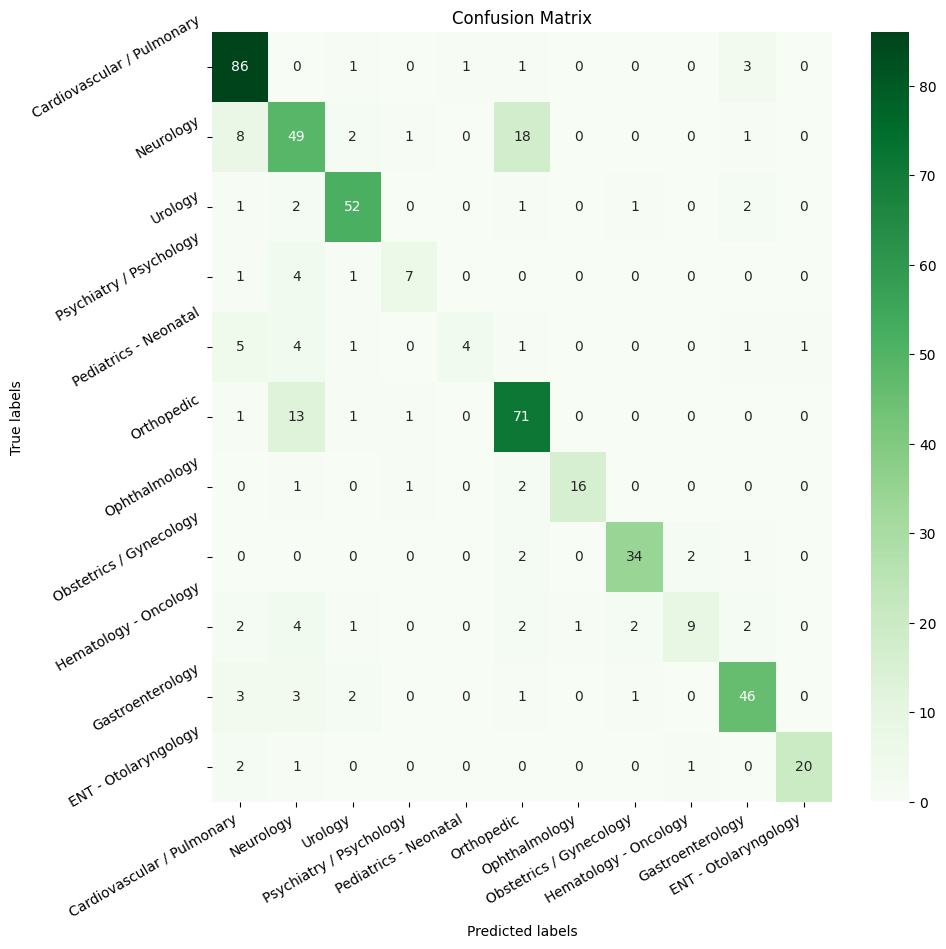

In [ ]:
cm = confusion_matrix(y_test2, y_test_pred_pca2, labels=category_list)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Neither accuracy nor F1-scores improve with PCA, there are still the same problems with 'Psychiatry/Psychology', 'Pediatrics', 'Hematology'.

#### SMOTE & LR

In [ ]:
smote_over_sample = SMOTE(sampling_strategy='auto')
X_train_smote_pca2, y_train_smote_pca2 = smote_over_sample.fit_resample(X_train_pca2, y_train2)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, random_state=1).fit(X_train_smote_pca2, y_train_smote_pca2)
y_test_pred_smote_pca2 = clf.predict(X_test_pca2)
print(classification_report(y_test2, y_test_pred_smote_pca2, labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.85      0.88      0.87        92
                 Neurology       0.66      0.62      0.64        79
                   Urology       0.85      0.88      0.87        59
   Psychiatry / Psychology       0.58      0.85      0.69        13
     Pediatrics - Neonatal       0.41      0.41      0.41        17
                Orthopedic       0.77      0.76      0.76        87
             Ophthalmology       0.94      0.85      0.89        20
   Obstetrics / Gynecology       0.85      0.87      0.86        39
     Hematology - Oncology       0.44      0.48      0.46        23
          Gastroenterology       0.88      0.80      0.84        56
      ENT - Otolaryngology       0.83      0.79      0.81        24

                  accuracy                           0.77       509
                 macro avg       0.73      0.74      0.74       509
              weighted avg       0.77      0.7

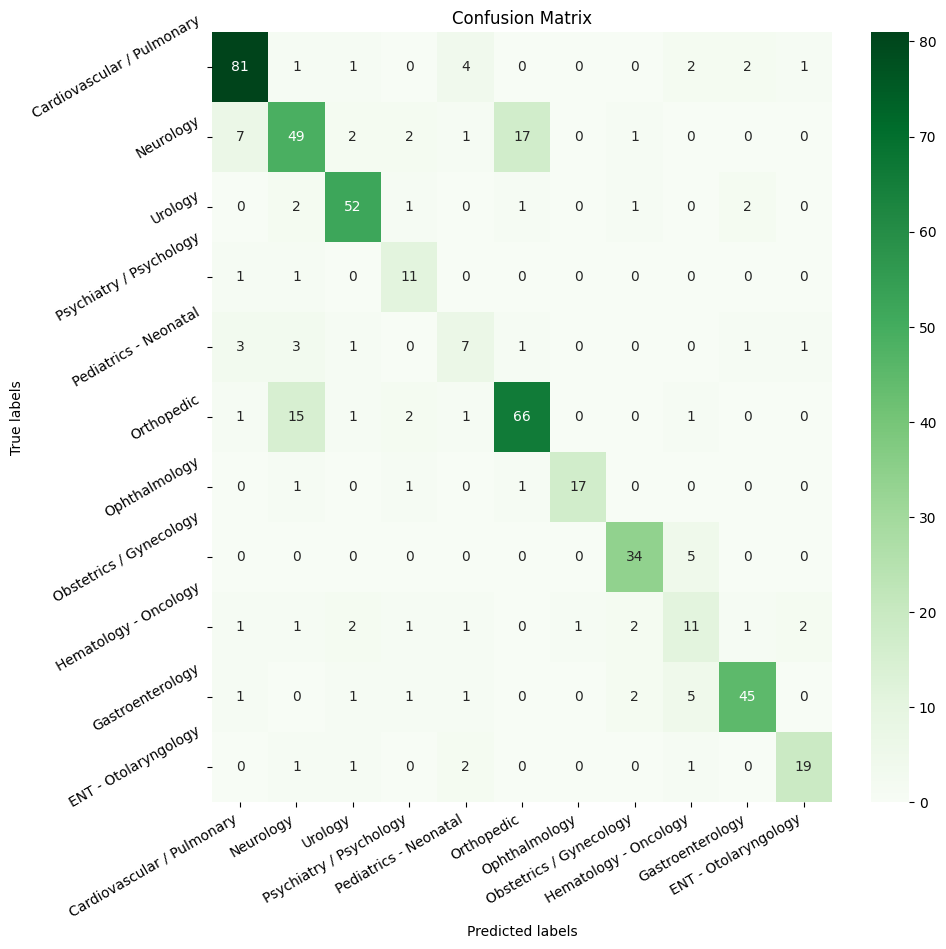

In [ ]:
cm = confusion_matrix(y_test2, y_test_pred_smote_pca2, labels=category_list)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

SMOTE is useful for the 3 badly predicted categories: 'Psychiatry/Psychology', 'Pediatrics', 'Hematology'.
We may accept this last model as the best one, with the idea to prefer to have the number of right prediction of minority classes high as possible.

### Final Considerations


Logistic Regression (LR) achieves an overall accuracy of 78%, yet the three less-represented classes face notable mispredictions. The introduction of SMOTE results in a slight decline in overall accuracy to 75%. However, it notably enhances the singular predictions of 'Psychiatry', 'Pediatrics', and 'Hematology', with respective F1-scores of 0.63, 0.35, and 0.49.

PCA in isolation yields an accuracy of 77%, maintaining challenges related to minority classes. The integration of SMOTE addresses these challenges, yielding a comparable result to the non-PCA scenario, with a global accuracy of 77%. PCA is not deemed essential in all scenarios.

Regardless of the approach, 'Orthopedic' is frequently misclassified as 'Neurology' and viceversa.

The determination of the optimal model is contingent on the specific context. In this analysis, emphasis is placed on prioritizing the improvement of minority class predictions.

#  Word2Vec (data_w2v)
Using data_w2v after category reduction in "Method 2".
Word2Vec is a popular technique in natural language processing (NLP) and machine learning that is used to represent words as vectors in a continuous vector space [12].
The primary idea behind Word2Vec is to capture semantic relationships between words by representing them as dense vectors, where words with similar meanings are positioned close to each other in the vector space. The model is trained on a large corpus of text, learning to predict the context in which words appear, as highlighted in the study of Desai et al.[4].
The training process involves adjusting the word vectors in such a way that the predicted context is close to the actual context. Once trained, the word vectors capture semantic relationships, and words with similar meanings have similar vector representations.

Note: the semantic context is very important for the method, it goes beyond the presence or absence of a word and is based instead on its semantic meaning.


In [ ]:
############### DATA PRE-PROCESSING #################

# pre-processing steps has to be performed in the following order
## 1) remove_stopwords -- removes all the stopwords from string
## 2) stem_text (optional) -- stems text w/ Porter stemmer (suited for Information Retrieval w/o word embeddings)
## 3) tokenize -- split text into tokens (CAVEAT: Gensim tokenizer removes digits too!) and returns a generator object

# example showing the effect of each of the 3 steps
sub = data_w2v.iloc[2]
report = sub['transcription'].strip() # use strip to remove any whitespace at BeginOfSentence and EndOfSentence positions
print(
    "Original report: {}\n1) remove_stopwords: {}\n2) stem_text: {}\n3) tokenize: {}\n"
    .format(report, remove_stopwords(report), stem_text(remove_stopwords(report)), list(tokenize(stem_text(remove_stopwords(report)))))
)

pproc_data = [list(tokenize(stem_text((remove_stopwords(transcription))))) for transcription in data_w2v['transcription'].astype(str)]


Original report: 2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationships.  Cardiac function is normal.  There is no significant chamber enlargement or hypertrophy.  There is no pericardial effusion or vegetations seen.  Doppler interrogation, including color flow imaging, reveals systemic venous return to the right atrium with normal tricuspid inflow.  Pulmonary outflow is normal at the valve.  Pulmonary venous return is to the left atrium.  The interatrial septum is intact.  Mitral inflow and ascending aorta flow are normal.  The aortic valve is trileaflet.  The coronary arteries appear to be normal in their origins.  The aortic arch is left-sided and patent with normal descending aorta pulsatility.
1) remove_stopwords: 2-D ECHOCARDIOGRAM,Multiple views heart great vessels reveal normal intracardiac great vessel relationships. Cardiac function normal. There significant chamber enlargement hypertrophy. There pericardial

Working with a noisy dataset, it is important to make some adjustments to the parameters of the algorithm to get better results.

In [ ]:
######### MODEL TRAINING #############################################

# Word2Vec params:
## sentences: an iterable that must be restartable (not just a generator!) to allow Word2Vec stream over data multiple times
## vector_size: dimensionality of the word vectors
## window: maximum distance between the current and predicted word within a sentence
## min_count: ignores all words with total frequency lower than this.
## negative: if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20)
## sg: training algorithm -- 1 for skip-gram; otherwise CBOW.
## workers: use these many worker threads to train the model (faster training with multicore machines)
## epochs: number of iterations (epochs) over the corpus.
## seed: seed for the random number generator.

word2vec = Word2Vec(sentences=pproc_data, vector_size=200, window=5, min_count=1, negative=10, sg=1, workers=1, epochs=30, seed=42)

print('word vectors size: {}'.format(word2vec.wv.vector_size))
print('matrix vectors size: {}x{}'.format(len(word2vec.wv.key_to_index), word2vec.wv.vector_size))

word vectors size: 200
matrix vectors size: 18580x200


The final combination of parameters was chosen to achieve the best trade-off between performance and computational cost. More precisely, the following parameters have the most significant influence:

1.   For vector_size we focused on lower values to reduce the computational time and to avoid the risk of overfitting, which gets higher the bigger the values we use, especially in a noisy dataset such as this one.
2.   For the window we used 5 in order to capture more of the context.
3.   Between sg (skip-gram) and CBOW (Continuos Bag of Words) we found that sg was better suited for our aim as it has better performance on semantic similarities.










In [ ]:
# SEMANTIC RETRIEVAL

data_embs = []
for sent in pproc_data:
     emb = sum([word2vec.wv.get_vector(word) for word in sent]) / len(sent)
     data_embs.append(emb)

# convert data_embs into a 2-dimensional array
data_embs = np.array(data_embs)
data_shape = data_embs.shape
print('dataset representation has size {} where:\n{} = medical reports\n{} = vectors size\n'.format(data_shape, data_shape[0], data_shape[1]))

# Each row of data_embs represents a given medical report in data and pproc_data -- thus, the row index points to the associated medical report
rand = random.randint(a=0, b=data_shape[0])
print('Report tokens: \n{}\n'.format(pproc_data[rand]))
print('Report-level vector representation: \n{}\n'.format(data_embs[rand]))

dataset representation has size (2034, 200) where:
2034 = medical reports
200 = vectors size

Report tokens: 
['preoper', 'diagnoses', 'term', 'pregnancy', 'nonreassur', 'fetal', 'heart', 'tracing', 'postop', 'diagnoses', 'term', 'pregnancy', 'nonreassur', 'fetal', 'heart', 'tracing', 'operation', 'primari', 'cesarean', 'section', 'low', 'transvers', 'incision', 'anesthesia', 'epidural', 'estim', 'blood', 'loss', 'ml', 'complications', 'none', 'condition', 'stable', 'drains', 'folei', 'catheter', 'indications', 'the', 'patient', 'year', 'old', 'g', 'para', 'edc', 'the', 'patient', 'began', 'have', 'prodrom', 'symptom', 'dai', 'prior', 'presentation', 'she', 'seen', 'nonstress', 'test', 'performed', 'thi', 'reveal', 'spontan', 'variable', 'appear', 'decelerations', 'she', 'given', 'iv', 'hydration', 'a', 'biophys', 'profil', 'obtained', 'provid', 'score', 'cm', 'fluid', 'pocket', 'found', 'therefore', 'admit', 'fetal', 'monitor', 'evaluation', 'she', 'chang', 'cervix', 'close', 'dai', '

## Visualization with UMAP
UMAP stands for Uniform Manifold Approximation and Projection and is a manifold learning technique for dimensionality reduction, so that data can be visualized in a 2D space [11].

Compared to T-SNE, at least some aggregation are separable from the others.

Note: UMAP is only useful to get an initial idea of the structure of the data, but really it doesn't give us any more information other than the fact that the dataset is noisy. Also it's a 2D representation of a dataset with much more dimensions.



[('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Neurology', (0.2, 0.6274509803921569, 0.17254901960784313)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP representations have size: (2034, 2)


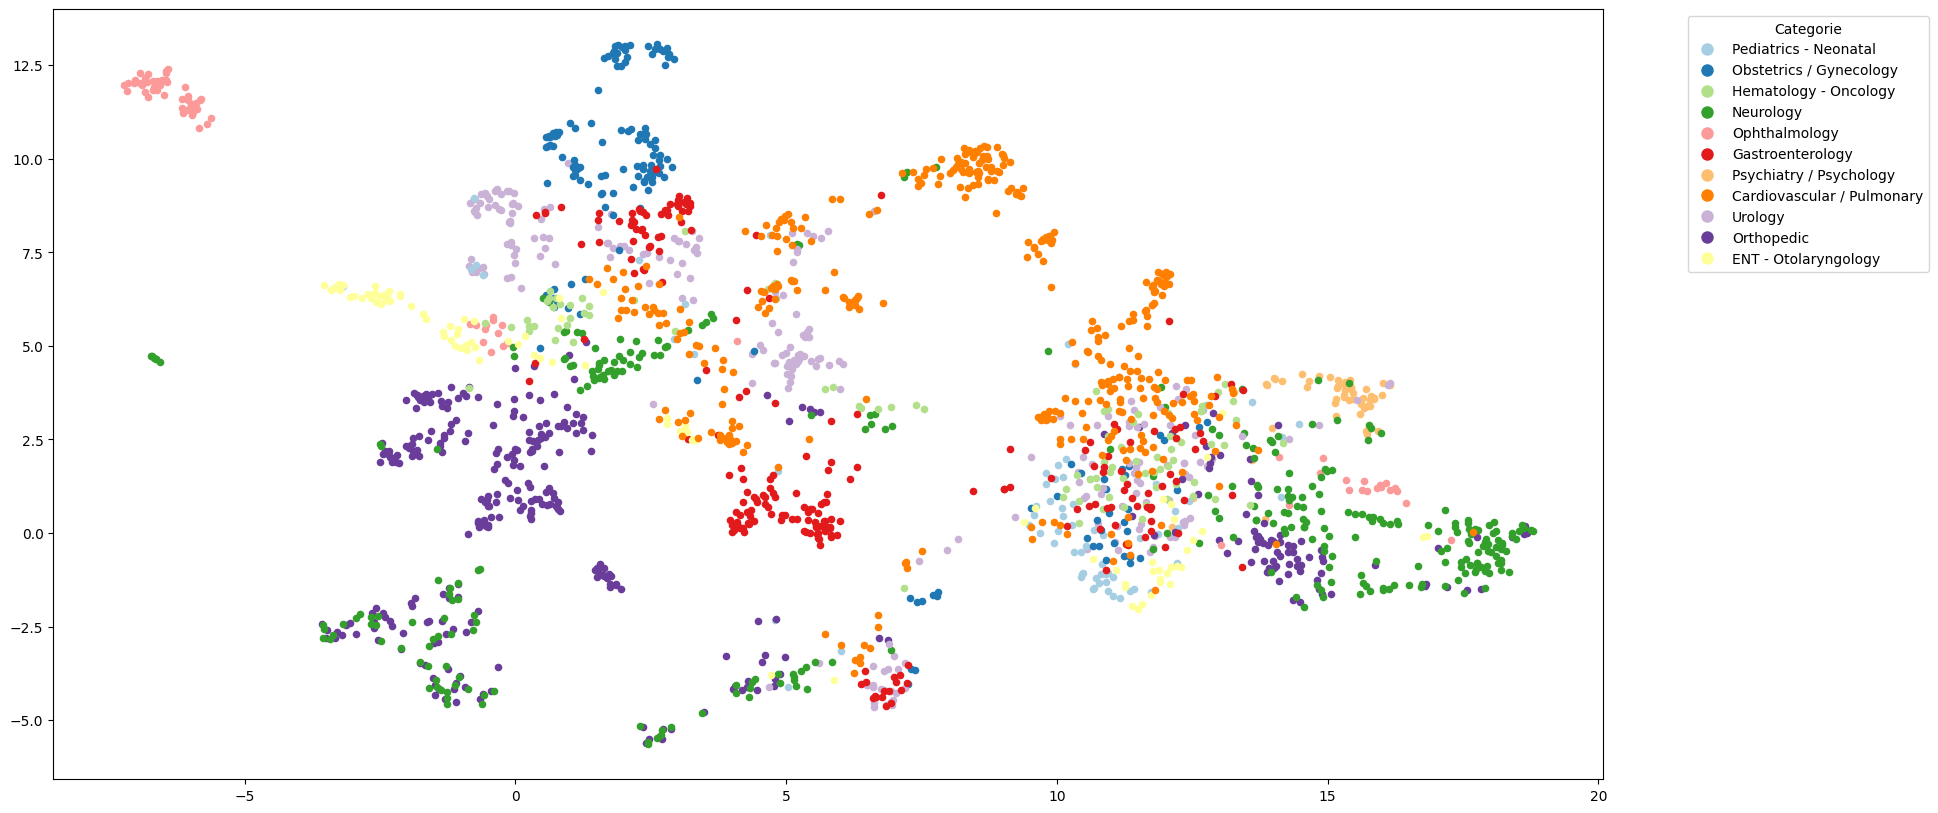

In [ ]:
labels_w2v=data_w2v['medical_specialty'].tolist()
categories_strings = labels_w2v
unique_categories = set(categories_strings)

# Creation of an automitic mapping procedure between categories and color
category_color_mapping = {category: color for category, color in zip(unique_categories, cycle(plt.cm.Paired.colors))}
categories = [(category, category_color_mapping[category]) for category in categories_strings]
print(categories)

# fit representations to UMAP -- specifying the size of the space after the reduction (i.e., 2)
umap_embs = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.5, spread=1.5).fit(data_embs)
print('UMAP representations have size: {}'.format(umap_embs.embedding_.shape))

# plot the representations learned by UMAP assigning to each point its associated concept
fig, ax = plt.subplots(figsize=(20,10))
fig.set_dpi(100)
x = umap_embs.embedding_[:,0]
y = umap_embs.embedding_[:,1]

for idx, concept in enumerate(data_w2v['transcription']):
    ax.scatter(x[idx], y[idx], color=categories[idx][1], label=categories[idx][0], s=20)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in category_color_mapping.items()]
ax.legend(handles=handles, title='Categorie', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Prediction

In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(data_embs, labels_w2v, stratify=labels_w2v,random_state=1)

### Logistic regression

In [ ]:
category_list_w2v = data_w2v.medical_specialty.unique()

clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, max_iter=1000, random_state=1, n_jobs=-1).fit(X_train_w2v, y_train_w2v)
y_test_pred_w2v= clf.predict(X_test_w2v)
print(classification_report(y_test_w2v,y_test_pred_w2v,labels=category_list_w2v))


                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.75      0.90      0.82        92
                 Neurology       0.70      0.72      0.71        79
                   Urology       0.84      0.73      0.78        59
   Psychiatry / Psychology       0.77      0.77      0.77        13
     Pediatrics - Neonatal       0.55      0.35      0.43        17
                Orthopedic       0.82      0.85      0.84        87
             Ophthalmology       0.94      0.85      0.89        20
   Obstetrics / Gynecology       0.88      0.95      0.91        39
     Hematology - Oncology       0.70      0.61      0.65        23
          Gastroenterology       0.79      0.79      0.79        56
      ENT - Otolaryngology       1.00      0.67      0.80        24

                  accuracy                           0.79       509
                 macro avg       0.79      0.74      0.76       509
              weighted avg       0.79      0.7

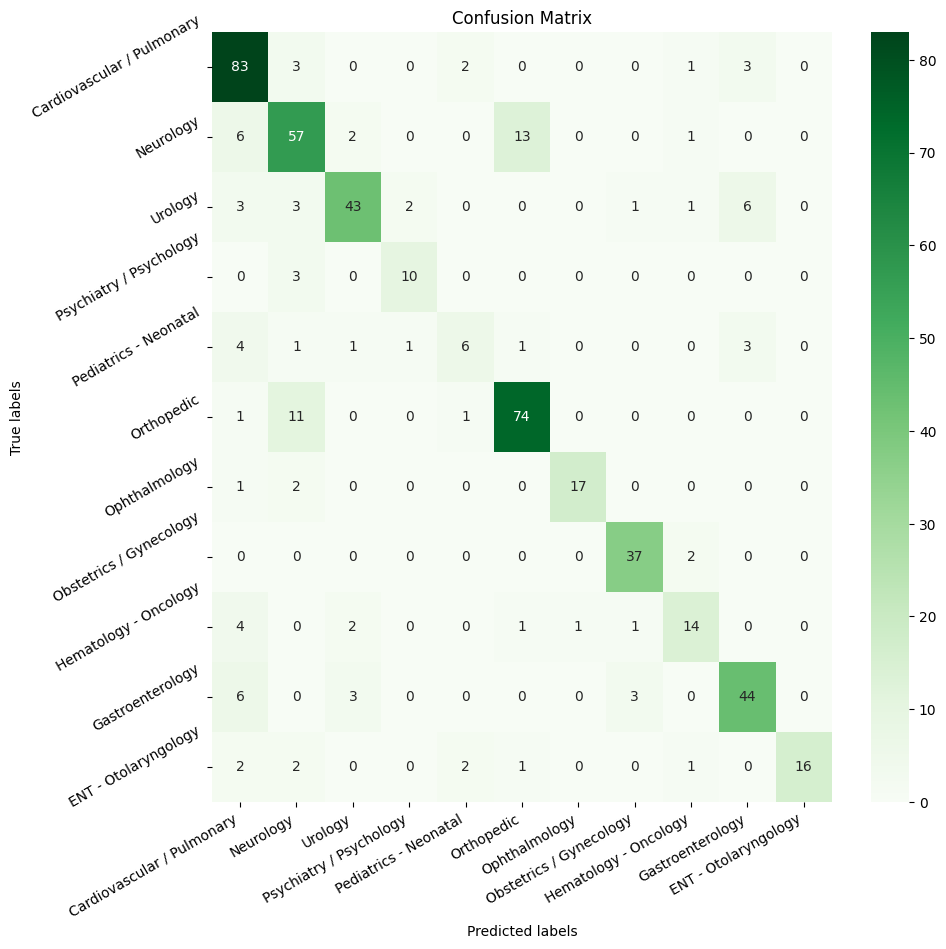

In [ ]:
cm = confusion_matrix(y_test_w2v, y_test_pred_w2v, labels=category_list_w2v)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list_w2v); ax.yaxis.set_ticklabels(category_list_w2v);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Word2Vec exhibits strong performance for both majority and minority categories from the outset, yet it fails to resolve the misclassification issue between 'Neurology' and 'Orthopedic'.

### SMOTE & LR
Using the sampling strategy parameter to improve prediction of "Pediatrics - Neonatal", that is the worst predicted class.

In [ ]:
smote_over_sample = SMOTE(sampling_strategy={'Pediatrics - Neonatal': 80})
X_train_smote, y_train_smote = smote_over_sample.fit_resample(X_train_w2v, y_train_w2v)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, max_iter=1000, random_state=1, n_jobs=-1).fit(X_train_smote, y_train_smote)
y_test_pred_smote = clf.predict(X_test_w2v)
print(classification_report(y_test_w2v, y_test_pred_smote, labels=category_list_w2v))


                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.77      0.90      0.83        92
                 Neurology       0.70      0.72      0.71        79
                   Urology       0.84      0.73      0.78        59
   Psychiatry / Psychology       0.77      0.77      0.77        13
     Pediatrics - Neonatal       0.45      0.53      0.49        17
                Orthopedic       0.83      0.85      0.84        87
             Ophthalmology       0.94      0.85      0.89        20
   Obstetrics / Gynecology       0.90      0.95      0.92        39
     Hematology - Oncology       0.72      0.57      0.63        23
          Gastroenterology       0.79      0.75      0.77        56
      ENT - Otolaryngology       1.00      0.67      0.80        24

                  accuracy                           0.79       509
                 macro avg       0.79      0.75      0.77       509
              weighted avg       0.79      0.7

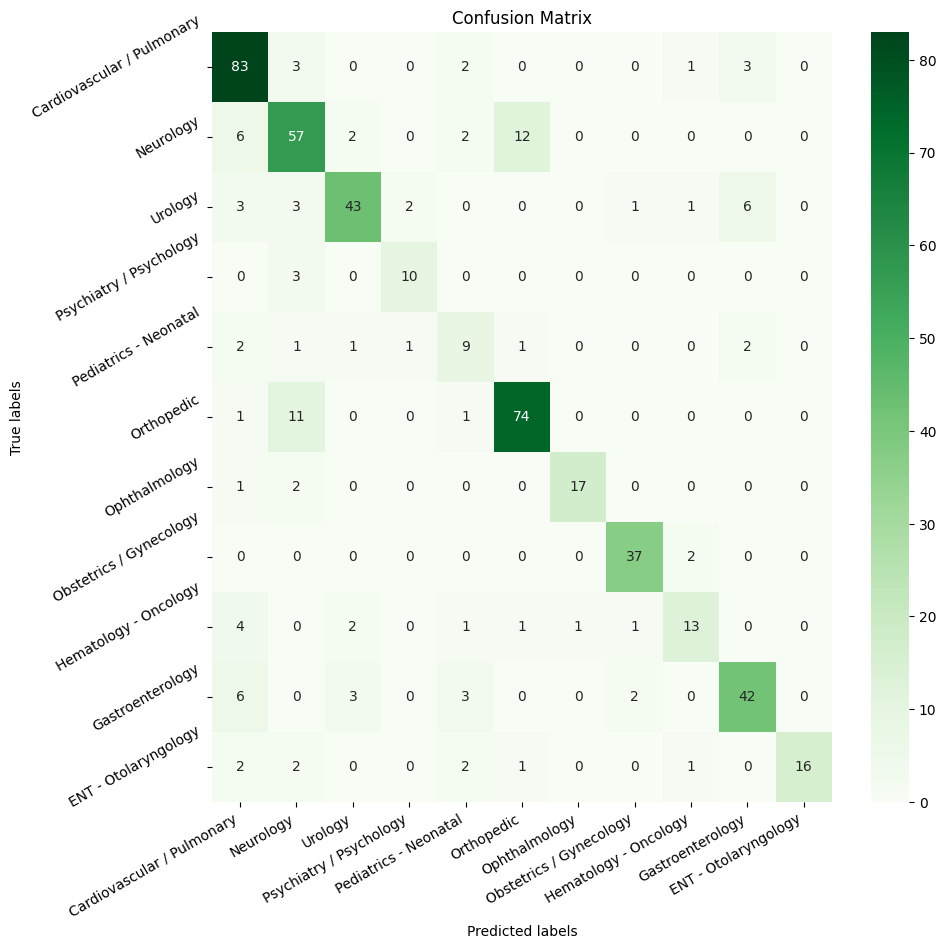

In [ ]:
cm = confusion_matrix(y_test_w2v, y_test_pred_smote, labels=category_list_w2v)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list_w2v); ax.yaxis.set_ticklabels(category_list_w2v);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

When applied solely to the "Pediatrics - Neonatal" category, SMOTE leads to an increase in the F1-score from 0.43 to 0.49 while keeping the overall accuracy of the model unchanged.

# Word2Vec (data2_spaCy)

Using data2_spaCy after spaCy processing

In [ ]:
############### DATA PRE-PROCESSING #################

# pre-processing steps has to be performed in the following order
## 1) remove_stopwords -- removes all the stopwords from string
## 2) stem_text (optional) -- stems text w/ Porter stemmer (suited for Information Retrieval w/o word embeddings)
## 3) tokenize -- split text into tokens (CAVEAT: Gensim tokenizer removes digits too!) and returns a generator object

# example showing the effect of each of the 3 steps
sub = data2_spaCy.iloc[2]
report = sub['transcription'].strip() # use strip to remove any whitespace at BeginOfSentence and EndOfSentence positions
print(
    "Original report: {}\n1) remove_stopwords: {}\n2) stem_text: {}\n3) tokenize: {}\n"
    .format(report, remove_stopwords(report), stem_text(remove_stopwords(report)), list(tokenize(stem_text(remove_stopwords(report)))))
)

pproc_data_spaCy = [list(tokenize(stem_text((remove_stopwords(transcription))))) for transcription in data2_spaCy['transcription'].astype(str)]


Original report: heart vessels intracardiac vessel Cardiac venous Pulmonary outflow Pulmonary venous interatrial septum Mitral inflow aortic valve coronary arteries aortic arch
1) remove_stopwords: heart vessels intracardiac vessel Cardiac venous Pulmonary outflow Pulmonary venous interatrial septum Mitral inflow aortic valve coronary arteries aortic arch
2) stem_text: heart vessel intracardiac vessel cardiac venou pulmonari outflow pulmonari venou interatri septum mitral inflow aortic valv coronari arteri aortic arch
3) tokenize: ['heart', 'vessel', 'intracardiac', 'vessel', 'cardiac', 'venou', 'pulmonari', 'outflow', 'pulmonari', 'venou', 'interatri', 'septum', 'mitral', 'inflow', 'aortic', 'valv', 'coronari', 'arteri', 'aortic', 'arch']



In [ ]:
######### MODEL TRAINING #############################################

# Word2Vec params:
## sentences: an iterable that must be restartable (not just a generator!) to allow Word2Vec stream over data multiple times
## vector_size: dimensionality of the word vectors
## window: maximum distance between the current and predicted word within a sentence
## min_count: ignores all words with total frequency lower than this.
## negative: if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20)
## sg: training algorithm -- 1 for skip-gram; otherwise CBOW.
## workers: use these many worker threads to train the model (faster training with multicore machines)
## epochs: number of iterations (epochs) over the corpus.
## seed: seed for the random number generator.

word2vec_spaCy = Word2Vec(sentences=pproc_data_spaCy, vector_size=500, window=5, min_count=1, negative=10, sg=1, workers=1, epochs=30, seed=42)

print('word vectors size: {}'.format(word2vec_spaCy.wv.vector_size))
print('matrix vectors size: {}x{}'.format(len(word2vec_spaCy.wv.key_to_index), word2vec_spaCy.wv.vector_size))

word vectors size: 500
matrix vectors size: 5502x500


 Note: If we had not dropped out null transcriptions after implementing the spaCy model, the following section would not have worked.

In [ ]:
# SEMANTIC RETRIEVAL

data_embs = []
for sent in pproc_data_spaCy:
     emb = sum([word2vec_spaCy.wv.get_vector(word) for word in sent]) / len(sent)
     data_embs.append(emb)

# convert data_embs into a 2-dimensional array
data_embs = np.array(data_embs)
data_shape = data_embs.shape
print('dataset representation has size {} where:\n{} = medical reports\n{} = vectors size\n'.format(data_shape, data_shape[0], data_shape[1]))

# Each row of data_embs represents a given medical report in data and pproc_data -- thus, the row index points to the associated medical report
rand = random.randint(a=0, b=data_shape[0])
print('Report tokens: \n{}\n'.format(pproc_data_spaCy[rand]))
print('Report-level vector representation: \n{}\n'.format(data_embs[rand]))

dataset representation has size (2034, 500) where:
2034 = medical reports
500 = vectors size

Report tokens: 
['intraocular', 'len', 'patient', 'ey', 'mydriacyl', 'neo', 'synephrin', 'ey', 'ey', 'ey', 'betadin', 'ey', 'corneal', 'lidocain', 'preservative', 'fre', 'anterior', 'chamber', 'corneal', 'anterior', 'capsular', 'forcep', 'tear', 'nucleu', 'nucleu', 'cortex', 'central', 'posterior', 'capsul', 'capsular', 'bag', 'wound', 'intraocular', 'len', 'keratom', 'blade', 'th', 'len', 'capsular', 'bag', 'anterior', 'capsular', 'len', 'miochol', 'anterior', 'wound', 'tobradex', 'ointment', 'ey', 'ey', 'pad', 'fox', 'patient']

Report-level vector representation: 
[-1.27428712e-03 -2.72655696e-01 -1.37687966e-01 -1.86372567e-02
  4.34522182e-02 -1.84798226e-01  2.05681801e-01  4.71350290e-02
 -7.41537381e-03 -3.48984468e-04  8.12939629e-02 -3.63761894e-02
 -1.38643280e-01  2.09610999e-01 -8.43117833e-02  1.07842930e-01
  4.79529910e-02  2.03343451e-01 -5.09990081e-02  4.32764627e-02
  1.698

## Visualization with UMAP



[('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Neurology', (0.2, 0.6274509803921569, 0.17254901960784313)), ('Cardiovascular / Pulmonary', (1.0, 0.4980392156862745, 0.0)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.6980392156862745, 0.8392156862745098)), ('Urology', (0.792156862745098, 0.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP representations have size: (2034, 2)


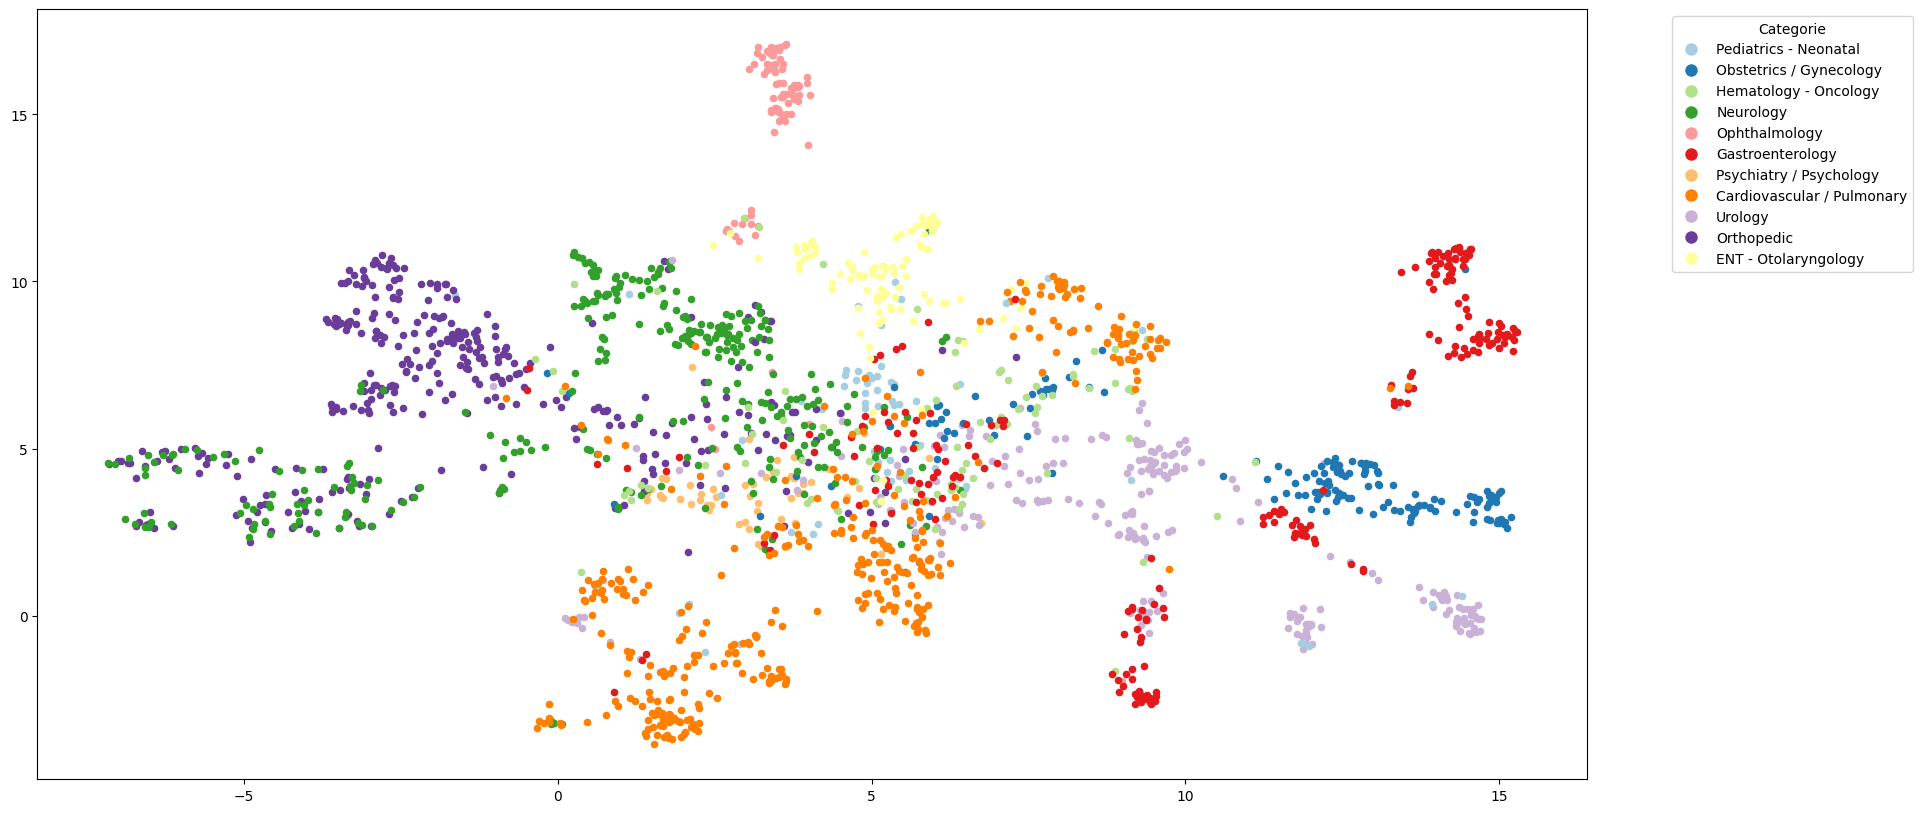

In [ ]:
labels_spaCy=data2_spaCy['medical_specialty'].tolist()
categories_strings = labels_spaCy
unique_categories = set(categories_strings)

# Creation of an automitic mapping procedure between categories and color
category_color_mapping = {category: color for category, color in zip(unique_categories, cycle(plt.cm.Paired.colors))}
categories = [(category, category_color_mapping[category]) for category in categories_strings]
print(categories)

# fit representations to UMAP -- specifying the size of the space after the reduction (i.e., 2)
umap_embs = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.5, spread=1.5).fit(data_embs)
print('UMAP representations have size: {}'.format(umap_embs.embedding_.shape))

# plot the representations learned by UMAP assigning to each point its associated concept
fig, ax = plt.subplots(figsize=(20,10))
fig.set_dpi(100)
x = umap_embs.embedding_[:,0]
y = umap_embs.embedding_[:,1]

for idx, concept in enumerate(data2_spaCy['transcription']):
    ax.scatter(x[idx], y[idx], color=categories[idx][1], label=categories[idx][0], s=20)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in category_color_mapping.items()]
ax.legend(handles=handles, title='Categorie', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

UMAP visualization shows that there is an area with greater superimposition and some aggregation are separable from the others still ('Ophthalmology'). The samples with similarities are all merged in single groups rather than being divided in smaller groups. From this plot we can also appreciate the cloud of overlapping 'Neurology' and 'Orthopedic' points.

## Prediction

In [ ]:
X_train_spaCy, X_test_spaCy, y_train_spaCy, y_test_spaCy = train_test_split(data_embs, labels_spaCy, stratify=labels_spaCy,random_state=1)

### Logistic regression

In [ ]:
category_list_spaCy = data2_spaCy.medical_specialty.unique()

clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, max_iter=1000, random_state=1, n_jobs=-1).fit(X_train_spaCy, y_train_spaCy)
y_test_pred_spaCy= clf.predict(X_test_spaCy)
print(classification_report(y_test_spaCy,y_test_pred_spaCy,labels=category_list_spaCy))


                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.82      0.91      0.86        92
                 Neurology       0.66      0.59      0.63        79
                   Urology       0.91      0.83      0.87        59
   Psychiatry / Psychology       0.73      0.85      0.79        13
     Pediatrics - Neonatal       0.50      0.41      0.45        17
                Orthopedic       0.71      0.83      0.77        87
             Ophthalmology       0.94      0.80      0.86        20
   Obstetrics / Gynecology       0.90      0.90      0.90        39
     Hematology - Oncology       0.65      0.57      0.60        23
          Gastroenterology       0.85      0.84      0.85        56
      ENT - Otolaryngology       0.95      0.79      0.86        24

                  accuracy                           0.79       509
                 macro avg       0.78      0.76      0.77       509
              weighted avg       0.79      0.7

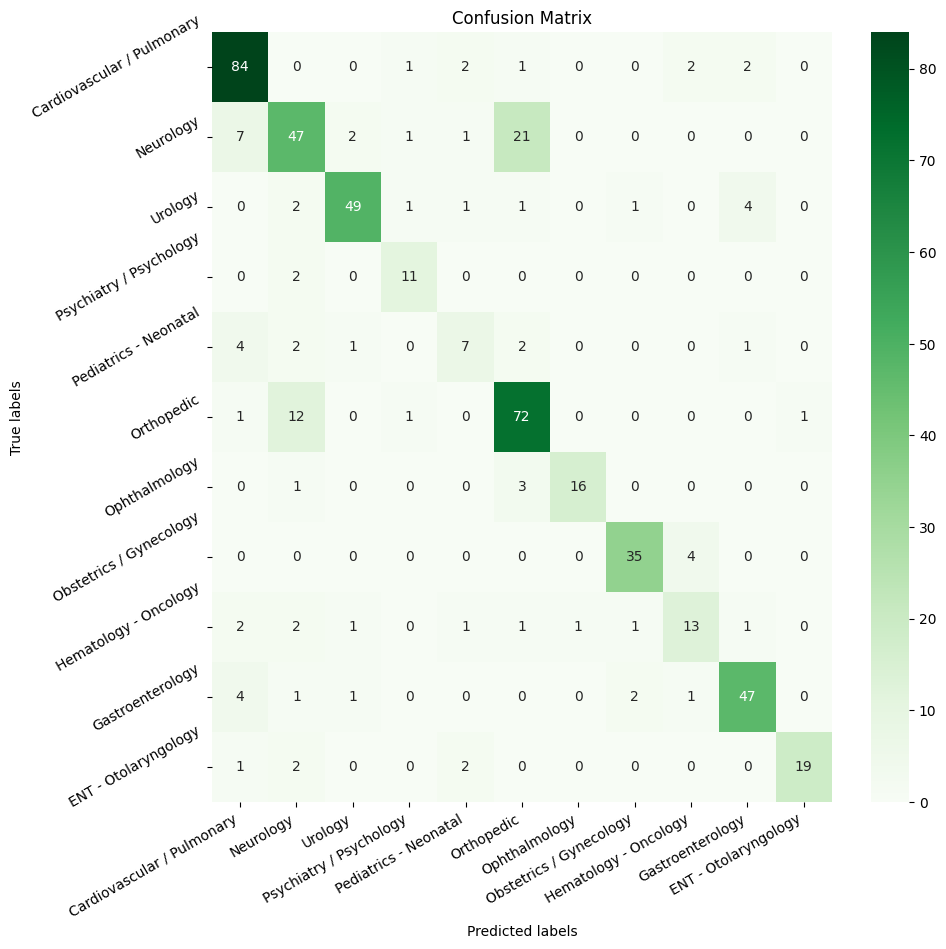

In [ ]:
cm = confusion_matrix(y_test_spaCy, y_test_pred_spaCy, labels=category_list_spaCy)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list_spaCy); ax.yaxis.set_ticklabels(category_list_spaCy);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Incorporating the processing with the SpaCy model maintains a good overall accuracy while further increasing the precision of minority classes.

### SMOTE & LR
Using the sampling strategy parameter to improve prediction of "Pediatrics - Neonatal", that is the worst predicted class.

In [ ]:
smote_over_sample = SMOTE(sampling_strategy={'Pediatrics - Neonatal': 87})
X_train_smote, y_train_smote = smote_over_sample.fit_resample(X_train_spaCy, y_train_spaCy)

In [ ]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, max_iter=1000, random_state=1, n_jobs=-1).fit(X_train_smote, y_train_smote)
y_test_pred_smote = clf.predict(X_test_spaCy)
print(classification_report(y_test_spaCy, y_test_pred_smote, labels=category_list_spaCy))


                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.81      0.89      0.85        92
                 Neurology       0.68      0.59      0.64        79
                   Urology       0.91      0.81      0.86        59
   Psychiatry / Psychology       0.73      0.85      0.79        13
     Pediatrics - Neonatal       0.40      0.47      0.43        17
                Orthopedic       0.71      0.83      0.77        87
             Ophthalmology       0.94      0.80      0.86        20
   Obstetrics / Gynecology       0.90      0.92      0.91        39
     Hematology - Oncology       0.68      0.57      0.62        23
          Gastroenterology       0.85      0.82      0.84        56
      ENT - Otolaryngology       0.95      0.79      0.86        24

                  accuracy                           0.78       509
                 macro avg       0.78      0.76      0.77       509
              weighted avg       0.79      0.7

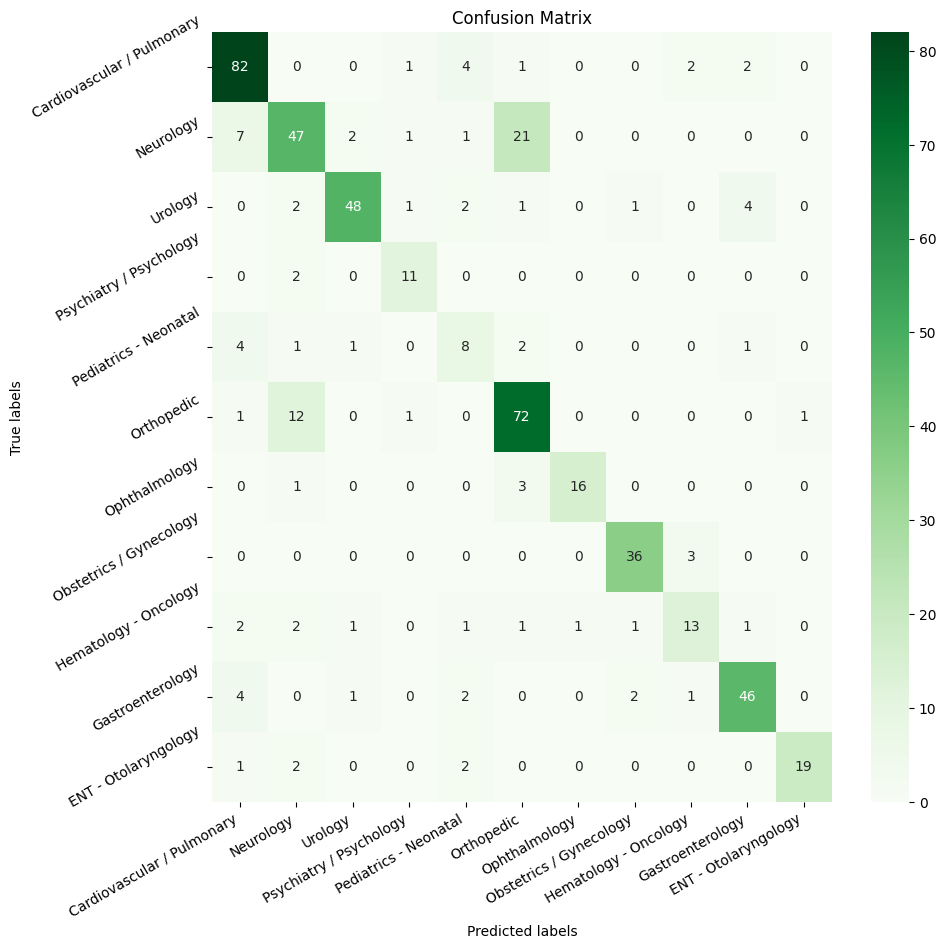

In [ ]:
cm = confusion_matrix(y_test_spaCy, y_test_pred_smote, labels=category_list_spaCy)

fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(category_list_spaCy); ax.yaxis.set_ticklabels(category_list_spaCy);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

When applied exclusively to the "Pediatrics - Neonatal" category, SMOTE leads to an increase in  recall for that class, but also to a decrease in the overall accuracy value.

# Final considerations

The Word2Vec model, compared to the previously used Tf-Idf method, excels in capturing non-trivial relationships within the data. This allows for an enhanced classification performance 79%, benefiting both majority and minority classes. Given that almost all classes maintain a high classification performance, SMOTE was applied to the largest minority class, resulting in improved overall performance.

Using SpaCy, the model struggled to achieve good performance for both majority and minority classes right from the start. In fact, applying SMOTE in this case proved to be less useful and unnecessary.

Despite all efforts, misclassifications persist, particularly between the 'Neurology' and 'Orthopedic' classes, indicating an ongoing challenge in distinguishing these two categories.

### Neurology vs Orthopedic
Extrapolation of wrong predictions of 'Neurology' and 'Orthopedic' transcriptions from the best prediction obtained in the Word2Vec (data_w2v) section after SMOTE.


In [ ]:
idx_total = range(0,data_w2v.shape[0])
idx_trn, idx_tst, labels_trn, labels_tst = train_test_split(idx_total,labels_w2v, stratify=labels_w2v,random_state=1)

In [ ]:
# wrong prediction neurology --> orthopedic
neuro=data_w2v.iloc[1120]
print(neuro['medical_specialty'])
print(neuro['transcription'])
print(pproc_data[1120])

Neurology
EXAM: , Lumbar spine CT without contrast.,HISTORY: , Back pain after a fall.,TECHNIQUE:,  Noncontrast axial images were acquired through the lumbar spine. Coronal and sagittal reconstruction views were also obtained.,FINDINGS: , There is no evidence for acute fracture or subluxation.  There is no spondylolysis or spondylolisthesis.  The central canal and neuroforamen are grossly patent at all levels.  There are no abnormal paraspinal masses. There is no wedge/compression deformity.  There is intervertebral disk space narrowing to a mild degree at L2-3 and L4-5.,Soft tissue windows demonstrate atherosclerotic calcification of the abdominal aorta, which is not dilated.  There was incompletely visualized probable simple left renal cyst, exophytic at the lower pole.,IMPRESSION:,1.  No evidence for acute fracture or subluxation.,2.  Mild degenerative changes.,3.  Probable left simple renal cyst.,
['exam', 'lumbar', 'spine', 'ct', 'contrast', 'history', 'back', 'pain', 'fall', 'tec

In [ ]:
# wrong prediction orthopedic --> neurology
ortho=data_w2v.iloc[387]
print(ortho['medical_specialty'])
print(ortho['transcription'])
print(pproc_data[387])

Orthopedic
CC: ,BLE weakness and numbness.,HX:, This 59 y/o RHM was seen and released from an ER 1 week prior to this presentation for a 3 week history of progressive sensory and motor deficits in both lower extremities. He reported numbness beginning about his trunk and slowly progressing to involve his lower extremities over a 4 week period. On presentation, he felt numb from the nipple line down. In addition, he began experiencing progressive weakness in his lower extremities for the past week. He started using a cane 5 days before being seen and had been having difficulty walking and traversing stairs. He claimed he could not stand. He denied loss of bowel or bladder control. However, he had not had a bowel movement in 3 days and he had not urinated 24 hours. His lower extremities had been feeling cold for a day. He denied any associated back or neck pain. He has chronic shortness of breath, but felt it had become worse. He had also been experiencing lightheadedness upon standing m

Many of the words from the neurologic transcription are specific to the orthopedic field, particularly when it comes to spinal imaging exams. Here are some examples:

1. **lumbar spine:** Lumbar spine, clearly an orthopedic term.
4. **history of back pain:** History of back pain, a common reason for orthopedic examinations.
8. **lumbar spine coronal/sagittal view:** Coronal/sagittal view of the lumbar spine.
9. **fracture:** Fracture, an orthopedic condition.
10. **subluxation:** Subluxation, a partial dislocation of a joint.
11. **spondylolysis:** Spondylolysis, an orthopedic condition of the spine.
14. **neuroforamen:** Neuroforamen, areas through which spinal nerves exit the spine.
16. **wedge compressive deformity:** Wedge compressive deformity, indicative of structural changes in the spine.
17. **intervertebral disk space:** Intervertebral disk space, an area of orthopedic interest.
20. **atherosclerotic calcification:** Atherosclerotic calcification, could be relevant in vascular orthopedic contexts.


Many words from the orthopedic transcription are clearly related to the neurological field. Here are some of the words specific to the neurological domain:

1. **numbness:** Numbness, indicative of neurological disorders.
5. **seizures:** Seizures, a neurological disorder.
6. **eeg:** Electroencephalogram, a test to assess brain activity.
7. **motor deficit:** Motor impairment, often associated with neurological problems.
8. **sensory deficit:** Sensory impairment, related to neurological issues.
12. **progressive weakness:** Progressive weakness, a significant neurological symptom.
14. **difficulty walking:** Difficulty in walking, common in neurological disorders.
16. **bowel/bladder control:** Control of bowel/bladder, related to neurological functions.
23. **truncal ataxia:** Truncal ataxia, a neurological dysfunction.
24. **reflexes:** Reflexes, evaluated in neurological examinations.



### Pediatrics - Neonatal category inspection
Extrapolation of wrong and correct predictions of 'Pediatrics - Neonatal' transcriptions from the best prediction obtained in the Word2Vec (data_w2v) section after SMOTE.

In [ ]:
# correct prediction
ped_correct=data2_spaCy.iloc[265]
print(ped_correct['medical_specialty']+' --> predicted in Pediatrics - Neonatal')
print(ped_correct['transcription'])
print(pproc_data_spaCy[265])

Pediatrics - Neonatal --> predicted in Pediatrics - Neonatal
bowel iron deficiency.,HISTORY OF 10-week-old female tube G-tube feedings admission.,PHYSICAL UNM anterior fontanelle Eyes Left ear ear Nose Bowel G-tube skin G-tube erythematous macular WBC lymphocytes Hemoglobin blood cell RDW MCV Sodium chloride CO2 BUN 7 creatinine glucose calcium abdominal flat bowel bowel Pepcid Reglan bowel Pedialyte J-tube stool fluids saline potassium chloride
['bowel', 'iron', 'deficiency', 'histori', 'of', 'week', 'old', 'femal', 'tube', 'g', 'tube', 'feed', 'admission', 'phys', 'unm', 'anterior', 'fontanel', 'ey', 'left', 'ear', 'ear', 'nose', 'bowel', 'g', 'tube', 'skin', 'g', 'tube', 'erythemat', 'macular', 'wbc', 'lymphocyt', 'hemoglobin', 'blood', 'cell', 'rdw', 'mcv', 'sodium', 'chlorid', 'co', 'bun', 'creatinin', 'glucos', 'calcium', 'abdomin', 'flat', 'bowel', 'bowel', 'pepcid', 'reglan', 'bowel', 'pedialyt', 'j', 'tube', 'stool', 'fluid', 'salin', 'potassium', 'chlorid']


In [ ]:
# wrong prediction
original=data_w2v.iloc[230]
print(original['medical_specialty']+' --> predicted in Orthopedic')
print(original['transcription'])
print(pproc_data[230])

Pediatrics - Neonatal --> predicted in Orthopedic
EXAM: , Two views of the pelvis.,HISTORY:,  This is a patient post-surgery, 2-1/2 months.  The patient has a history of slipped capital femoral epiphysis (SCFE) bilaterally.,TECHNIQUE: , Frontal and lateral views of the hip and pelvis were evaluated and correlated with the prior film dated MM/DD/YYYY.  Lateral view of the right hip was evaluated.,FINDINGS:,  Frontal view of the pelvis and a lateral view of the right hip were evaluated and correlated with the patient's most recent priors dated MM/DD/YYYY.  Current films reveal stable appearing post-surgical changes.  Again demonstrated is a single intramedullary screw across the left femoral neck and head.  There are 2 intramedullary screws through the greater trochanter of the right femur.  There is a lucency along the previous screw track extending into the right femoral head and neck.  There has been interval removal of cutaneous staples and/or surgical clips.  These were previously s

From the wrong predicted transcription, many words are specific to the orthopedic field, particularly when it comes to spinal imaging exams. Here are some words related to orthopedics:

- lumbar
- spine
- fracture
- subluxation
- spondylolysis
- neuroforamen
- paraspinous masses
- wedge compression deformity
- intervertebral disk space
- L-spine
- soft tissue window
- atherosclerotic calcifications

There don't seem to be specific words related to the pediatric field. However, some words may be common in pediatric contexts, such as "week old female" and "tube feed" (feeding through a tube), which may refer to pediatric patients. Additionally, "g tube" and "j tube" are often used in pediatric contexts to indicate specific types of gastrostomies or jejunostomies.

### Comparison with the original
**Method 1**: the main difference is that PCA was performed after.

After having applied PCA correctly only on the train set, the expected result of our analysis should have been worse compare to the original work with data-leakage problem, which reached an accuracy of 38%; however, it is actually better (42%), probably because we also accounted for the whole of the transcriptions, correcting the "lemmatize_text" function.

In both our project and the original one, PCA leads to F1-scores equal to zero for some classes, that are never predicted. This indicates that PCA is not appropriate.

**Method 2**: there is a great increase in accuracy, both in the original (62% with PCA + LR, 65% with PCA + LR + SMOTE) and in our version (77% with PCA + LR both with and without SMOTE).

In our case the category 'Radiology' is removed, as well as void transcriptions after spaCy model application, and PCA is applied correctly (that would have likely being misclassified), which is probably the reason why our results are better.


**SMOTE**: In the original project, SMOTE had been utilized with the sampling strategy = 'minority'. In our case, we chose to tailor the sampling strategy according to the needs and objectives of each prediction type, resulting in overall more satisfactory outcomes.

Using this method, the overall accuracy is sometimes lowered, but we trade it for a much better prediction of minority classes.

**W2V**: The Word2Vec model enables the definition and understanding of intrinsic semantic relationships, allowing for classification even without considering class imbalance. Thanks to its combination with the biomedical knowledge of spaCy model, we were able to reach satisfactory predictions across all classes, with an overall accuracy of 79%, eliminating the need to implement SMOTE.






# Conclusion and future improvements

In conclusion, this project successfully addressed the limitations of the original study, demonstrating significant improvements in classification performance. The strategic integration of category reduction, Word2Vec, and SpaCy models contributed to enhanced predictive accuracy, particularly for minority classes. While PCA did not yield significant improvements, the overall project highlights the importance of tailored preprocessing techniques in optimizing medical transcription classification.

To address this aim without overly reducing category diversity, a potential solution is to explore advanced machine/deep learning models. These models can uncover hidden relationships between words, offering insights into nuanced patterns.

Moreover, to test different seeds could be crucial to assess the consistency and reliability of the results in the model.

# References

1. Pruneski JA, Pareek A, Nwachukwu BU, Martin RK, Kelly BT, Karlsson J, Pearle AD, Kiapour AM, Williams RJ 3rd. Natural language processing: using artificial intelligence to understand human language in orthopedics. Knee Surg Sports Traumatol Arthrosc. 2023 Apr;31(4):1203-1211. doi: 10.1007/s00167-022-07272-0. Epub 2022 Dec 7. PMID: 36477347.


2. Arivazhagan N, Van Vleck TT. Natural Language Processing Basics. Clin J Am Soc Nephrol. 2023 Mar 1;18(3):400-401. doi: 10.2215/CJN.0000000000000081. Epub 2023 Feb 8. PMID: 36763809; PMCID: PMC10103357.


3. Ferrario A, Demiray B, Yordanova K, Luo M, Martin M. Social Reminiscence in Older Adults' Everyday Conversations: Automated Detection Using Natural Language Processing and Machine Learning. J Med Internet Res. 2020 Sep 15;22(9):e19133. doi: 10.2196/19133. PMID: 32866108; PMCID: PMC7525396.


4. Desai, Antonio, et al. "Word2vec Word Embedding-Based Artificial Intelligence Model in the Triage of Patients with Suspected Diagnosis of Major Ischemic Stroke: A Feasibility Study." International Journal of Environmental Research and Public Health 19.22 (2022): 15295.


5. Jentsch, Patrick, and Stephan Porada. "From Text to Data. Digitization, Text Analysis and Corpus Linguistics." Digital Methods in the Humanities. Challenges, Ideas, Perspectives (2021): 89-128.

6. https://en.wikipedia.org/wiki/Tf%E2%80%93idf

7. https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

8. https://arxiv.org/pdf/1106.1813.pdf

9. https://en.wikipedia.org/wiki/Principal_component_analysis

10. https://allenai.github.io/scispacy/

11. https://umap-learn.readthedocs.io/en/latest/

12. https://en.wikipedia.org/wiki/Word2vec
